In [ ]:
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
H, W = 1000, 1000
a = 5
N = 20
r = 3

class Lattice:
  def __init__(self, lengths, angles):
    self.length = lengths
    self.angle = angles
    self.a = lengths[0]
    self.b = lengths[1]
    self.c = lengths[2]
    self.alpha = angles[0]/180*np.pi
    self.beta = angles[1]/180*np.pi
    self.gamma = angles[2]/180*np.pi
    
    self.ab = self.a*self.b*np.cos(self.gamma)
    self.ba = self.a*self.b*np.cos(self.gamma)

    self.bc = self.b*self.c*np.cos(self.alpha)
    self.cb = self.b*self.c*np.cos(self.alpha)

    self.ca = self.c*self.a*np.cos(self.beta)
    self.ac = self.c*self.a*np.cos(self.beta)

    self.a_b = np.sqrt(self.a**2 + self.b**2 - 2*self.a*self.b*np.cos(self.gamma))
    self.b_a = np.sqrt(self.a**2 + self.b**2 - 2*self.a*self.b*np.cos(self.gamma))

    self.b_c = np.sqrt(self.b**2 + self.c**2 - 2*self.b*self.c*np.cos(self.alpha))
    self.c_b = np.sqrt(self.b**2 + self.c**2 - 2*self.b*self.c*np.cos(self.alpha))

    self.c_a = np.sqrt(self.c**2 + self.a**2 - 2*self.c*self.a*np.cos(self.beta))
    self.a_c = np.sqrt(self.c**2 + self.a**2 - 2*self.c*self.a*np.cos(self.beta))
  
  def index_to_parallelogram(self, ind_1, ind_2, ind_3):
    if ind_1 == ind_2 == ind_3 == 1:
      length_1 = self.b_a
      length_2 = self.c_a
      angle = np.arccos((self.bc-self.ca-self.ba+self.a**2)/(self.b_a*self.c_a))
    elif (ind_1 == ind_2 == 1) and (ind_3 == 0):
      length_1 = self.c
      length_2 = self.b_a
      angle = np.arccos((self.bc-self.ac)/(self.b_a*self.c))
    elif (ind_2 == ind_3 == 1) and (ind_1 == 0):
      length_1 = self.a
      length_2 = self.c_b
      angle = np.arccos((self.ca-self.ba)/(self.c_b*self.a))
    elif (ind_3 == ind_1 == 1) and (ind_2 == 0):
      length_1 = self.b
      length_2 = self.a_c
      angle = np.arccos((self.ab-self.cb)/(self.a_c*self.b))
    elif (ind_1 == 1) and (ind_2 == ind_3 == 0):
      length_1 = self.b
      length_2 = self.c
      angle = self.alpha
    elif (ind_2 == 1) and (ind_3 == ind_1 == 0):
      length_1 = self.c
      length_2 = self.a
      angle = self.beta
    elif (ind_3 == 1) and (ind_1 == ind_2 == 0):
      length_1 = self.a
      length_2 = self.b
      angle = self.gamma
    else:
      raise print("Invalid indexes inputted.")
    
    return length_1, length_2, angle/np.pi*180

  def axis_length(self, index, x, y):
    l_a, l_b, theta = self.index_to_parallelogram(index[0], index[1], index[2])
    length = np.sqrt((l_a*x)**2+(l_b*y)**2+2*l_a*l_b*x*y*np.cos(theta/180*np.pi))
    return length

def generate_lattice_image(lattice, index, H=H, W=W, a=a, N=N, r=r):
  lattice_image = np.zeros((H, W))
  l_a, l_b, theta = lattice.index_to_parallelogram(index[0], index[1], index[2])
  center = (H//2, W//2)

  for x in range(-N, N+1):
    for y in range(-N, N+1):
      position_x = center[0]+int(a*(x*l_a+y*l_b*np.cos(theta/180*np.pi)))
      position_y = center[1]+int(a*y*l_b*np.sin(theta/180*np.pi))
      position = (position_y, position_x)
      lattice_image = cv2.circle(lattice_image, position, r, 1, thickness=-1)
  
  return lattice_image

def simulate_matching(
    substrate: Lattice,
    target: Lattice,
    substrate_indexes: list = [(1,0,0), (1,1,0), (1,1,1)],
    target_indexes: list = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)],
    step: float = 1,
    thresh: int = 800,
):

  angles = np.arange(0, 90+step, step=step)
  out = {}
  pbar = tqdm(total=len(substrate_indexes)*len(target_indexes)*len(angles))
  for base_index in substrate_indexes:
    for on_index in target_indexes:
      head = f"Substrate({base_index[0]}{base_index[1]}{base_index[2]})//Target({on_index[0]}{on_index[1]}{on_index[2]})"
      base = generate_lattice_image(substrate, base_index)
      on = generate_lattice_image(target, on_index)
      y = []
      for angle in angles:
        trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
        on_rot = cv2.warpAffine(on, trans, (W, H))
        value = np.sum((on_rot*base)[H//4:H//4*3,W//4:W//4*3])
        y.append(value)
        pbar.update(1)
      out[head] = {
          "angle": angles,
          "overlap": y
      }
      ind_max = np.argmax(y)
      if y[ind_max] > thresh:
        angle = angles[ind_max]
        trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
        on_rot = cv2.warpAffine(on, trans, (W, H))
        print(f"\n{head}, θ={angle:.1f}°, overlapping={y[ind_max]:.0f}px")
        base_show = cv2.cvtColor((base*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        on_rot_show = cv2.cvtColor((on_rot*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        
        base_show[:,:,0] = 0
        base_show[:,:,2] = 0
        on_rot_show[:,:,0] = 0
        on_rot_show[:,:,1] = 0
        show_image = (255-base_show/2-on_rot_show/2)[H//4:H//4*3,W//4:W//4*3]
        
        h, w, _ = show_image.shape

        s_a, s_b, s_angle = substrate.index_to_parallelogram(base_index[0], base_index[1], base_index[2])
        t_a, t_b, t_angle = target.index_to_parallelogram(on_index[0], on_index[1], on_index[2])

        cv2.line(
            show_image,
            pt1=(w//2, h//2),
            pt2=(w//2+int(s_a*np.sin(-0/180*np.pi)*a), h//2-int(s_a*np.cos(-0/180*np.pi)*a)),
            color=(255, 0, 255),
            thickness=2,
        )
        cv2.line(
            show_image,
            pt1=(w//2, h//2),
            pt2=(w//2+int(s_b*np.sin((-s_angle-0)/180*np.pi)*a), h//2-int(s_b*np.cos((-s_angle-0)/180*np.pi)*a)),
            color=(255, 0, 255),
            thickness=2,
        )
        cv2.line(
            show_image,
            pt1=(w//2, h//2),
            pt2=(w//2+int(t_a*np.sin(-angle/180*np.pi)*a), h//2-int(t_a*np.cos(-angle/180*np.pi)*a)),
            color=(255, 255, 0),
        )
        cv2.line(
            show_image,
            pt1=(w//2, h//2),
            pt2=(w//2+int(t_b*np.sin((-t_angle-angle)/180*np.pi)*a), h//2-int(t_b*np.cos((-t_angle-angle)/180*np.pi)*a)),
            color=(255, 255, 0),
        )
        show_image = cv2.rotate(show_image, cv2.ROTATE_90_CLOCKWISE)
        cv2_imshow(show_image)
        print("")
  pbar.close()

  return out


def calc_mismatch(lattice_1, miller_1, ab_11, ab_12, lattice_2, miller_2, ab_21, ab_22):
  l_11 = lattice_1.axis_length(miller_1, ab_11[0], ab_11[1])
  l_12 = lattice_1.axis_length(miller_1, ab_12[0], ab_12[1])
  l_21 = lattice_2.axis_length(miller_2, ab_21[0], ab_21[1])
  l_22 = lattice_2.axis_length(miller_2, ab_22[0], ab_22[1])

  S = (l_11*l_12+l_21*l_22)/2
  da = (l_21-l_11)/l_11*100
  db = (l_22-l_12)/l_12*100
  print(f"S\t\1a\t1b\t2a\t2b\tΔa\tΔb")
  print(f"{S:.0f}\t{l_11:.2f}\t{l_12:.2f}\t{l_21:.2f}\t{l_22:.2f}\t{da:.2f}\t{db:.2f}")

In [ ]:
crystall = {
    "Ge": Lattice([5.658, 5.658, 5.658], [90, 90, 90]),
    "FeGe": Lattice([4.6484, 4.6484, 4.6484], [90.0000, 90.0000, 90.0000]),
    "FeGe2": Lattice([5.8958, 5.8958, 4.9178], [90.0000, 90.0000, 90.0000]),
    "PdGe": Lattice([6.2597, 5.8083, 3.4676], [90.0000, 90.0000, 90.0000]),
    "Pd2Ge": Lattice([6.7002, 6.7002, 3.4080], [90.0000, 90.0000, 120.0000]),
    "CoGe_1": Lattice([11.5958, 3.7899, 4.9228], [90.0000, 101.1000, 90.0000]),
    "CoGe_2": Lattice([4.6405, 4.6405, 4.6405], [90.0000, 90.0000, 90.0000]),
    "Pt3Ge": Lattice([5.4650, 5.4650, 7.9865], [90.0000, 90.0000, 90.0000]),
    "PtGe": Lattice([6.0719, 5.7263, 3.6821], [90.0000, 90.0000, 90.0000]),
    "Cu3Ge": Lattice([5.3303, 4.1734, 4.5301], [90.0000, 90.0000, 90.0000]),
}

  0%|          | 0/18921 [00:00<?, ?it/s]


Substrate(100)//Target(111), θ=0.0°, overlapping=1409px


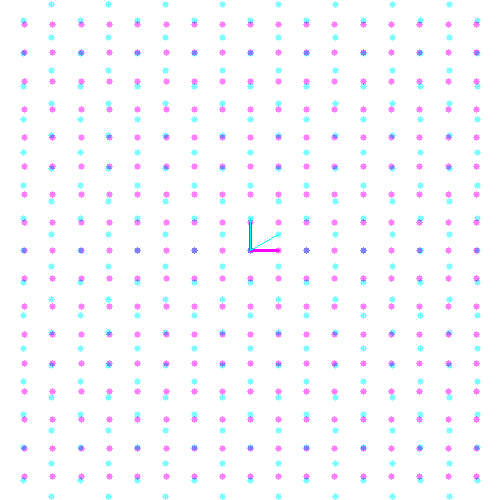



Substrate(110)//Target(100), θ=35.2°, overlapping=1313px


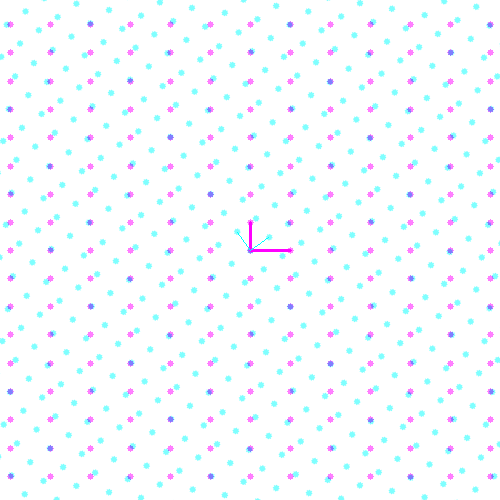



Substrate(110)//Target(010), θ=35.2°, overlapping=1313px


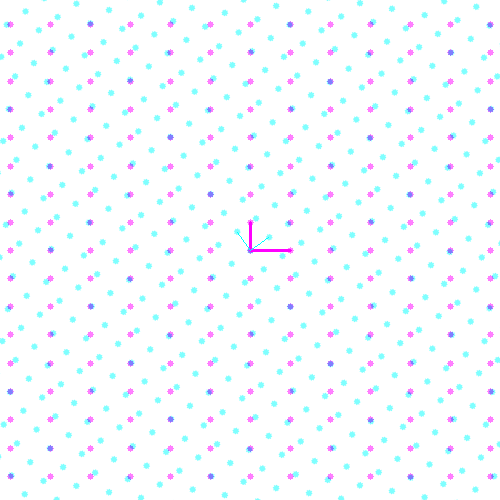



Substrate(110)//Target(001), θ=35.2°, overlapping=1313px


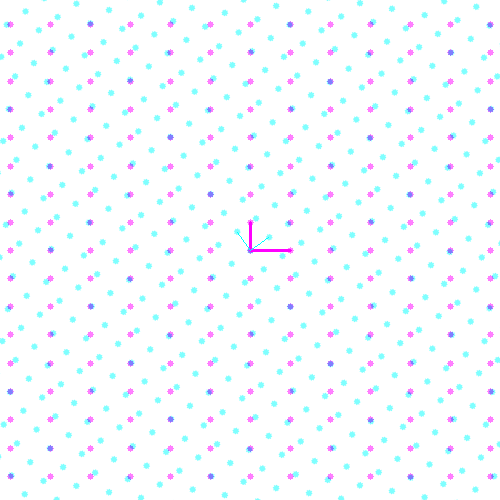



Substrate(110)//Target(110), θ=35.3°, overlapping=2532px


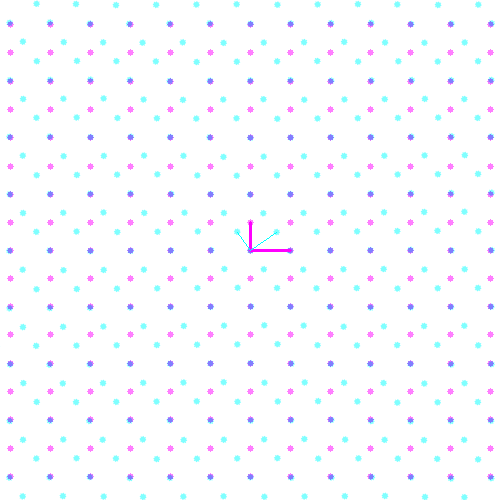



Substrate(110)//Target(011), θ=35.3°, overlapping=2532px


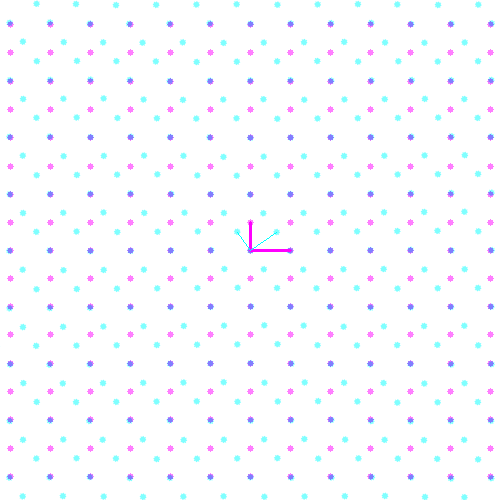



Substrate(110)//Target(101), θ=35.3°, overlapping=2532px


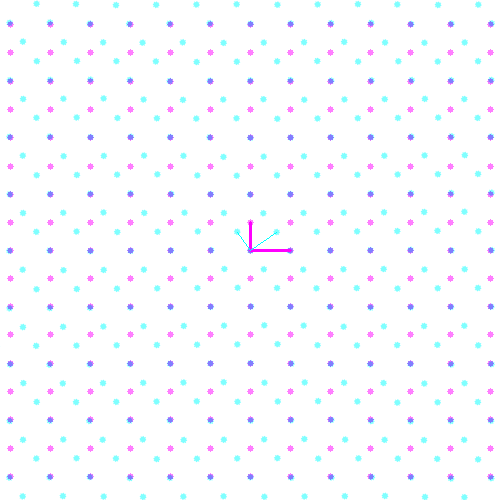



Substrate(110)//Target(111), θ=90.0°, overlapping=847px


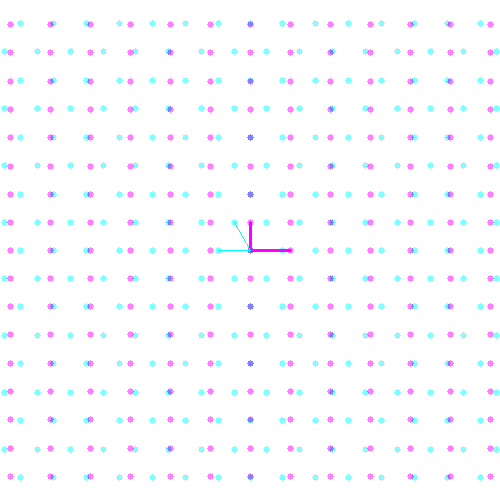

In [ ]:
out = simulate_matching(crystall["Ge"], crystall["FeGe"], step=0.1)

# FeGeみるやつ

In [ ]:
import plotly.graph_objects as go

In [ ]:
9.7, 35.2, 54.8, 80.3

In [ ]:
out.keys()

dict_keys(['Substrate(100)//Target(100)', 'Substrate(100)//Target(010)', 'Substrate(100)//Target(001)', 'Substrate(100)//Target(110)', 'Substrate(100)//Target(011)', 'Substrate(100)//Target(101)', 'Substrate(100)//Target(111)', 'Substrate(110)//Target(100)', 'Substrate(110)//Target(010)', 'Substrate(110)//Target(001)', 'Substrate(110)//Target(110)', 'Substrate(110)//Target(011)', 'Substrate(110)//Target(101)', 'Substrate(110)//Target(111)', 'Substrate(111)//Target(100)', 'Substrate(111)//Target(010)', 'Substrate(111)//Target(001)', 'Substrate(111)//Target(110)', 'Substrate(111)//Target(011)', 'Substrate(111)//Target(101)', 'Substrate(111)//Target(111)'])

In [ ]:
key_list = [
     "Substrate(100)//Target(100)",
     "Substrate(100)//Target(110)",
     "Substrate(100)//Target(111)",
     "Substrate(110)//Target(100)",
     "Substrate(110)//Target(110)",
     "Substrate(110)//Target(111)",
     "Substrate(111)//Target(100)",
     "Substrate(111)//Target(110)",
     "Substrate(111)//Target(111)",
]

z = np.zeros((1, 901))
for key in key_list:
  angles, overlap = out[key]["angle"], out[key]["overlap"]
  z = np.vstack(
      (
          z,
        overlap
      )
  )
z = z[1:]

In [ ]:

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=angles,
        y=key_list[::-1],
        z=z[::-1],
        colorscale="viridis"
    )
)
fig.update_layout(
    xaxis_title="<i>θ</i> [deg]",
    yaxis_title="",
    width=800,
    height=500
)


Substrate(110)//Target(110), θ=35.2°, overlapping=2511px


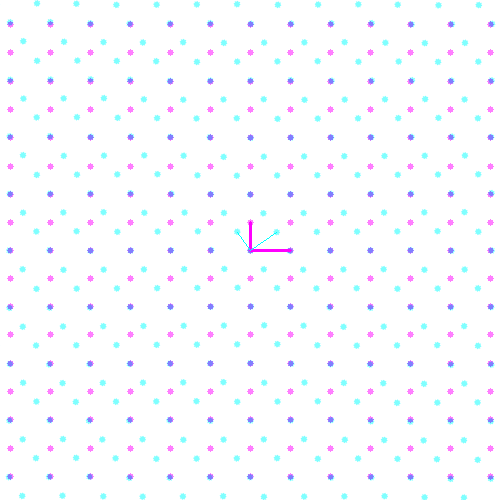



Substrate(110)//Target(110), θ=74.3°, overlapping=837px


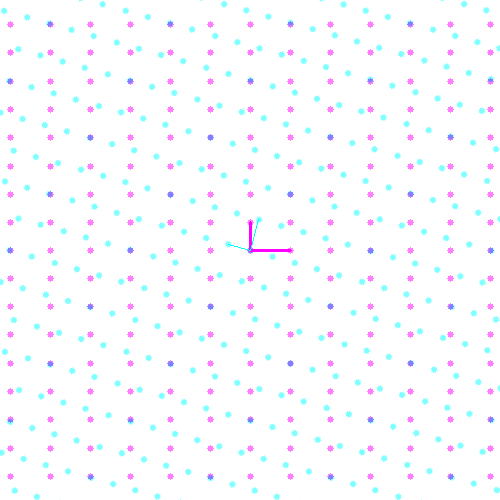

In [ ]:
angles = [35.2, 74.3]
out = {}
base_index = (1,1,0)
on_index = (1,1,0)
substrate = crystall["Ge"]
target = crystall["FeGe"]
head = f"Substrate({base_index[0]}{base_index[1]}{base_index[2]})//Target({on_index[0]}{on_index[1]}{on_index[2]})"
base = generate_lattice_image(substrate, base_index)
on = generate_lattice_image(target, on_index)

for angle in angles:
  trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
  on_rot = cv2.warpAffine(on, trans, (W, H))
  value = np.sum((on_rot*base)[H//4:H//4*3,W//4:W//4*3])
  trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
  on_rot = cv2.warpAffine(on, trans, (W, H))
  print(f"\n{head}, θ={angle:.1f}°, overlapping={value:.0f}px")
  base_show = cv2.cvtColor((base*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
  on_rot_show = cv2.cvtColor((on_rot*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

  base_show[:,:,0] = 0
  base_show[:,:,2] = 0
  on_rot_show[:,:,0] = 0
  on_rot_show[:,:,1] = 0
  show_image = (255-base_show/2-on_rot_show/2)[H//4:H//4*3,W//4:W//4*3]

  h, w, _ = show_image.shape

  s_a, s_b, s_angle = substrate.index_to_parallelogram(base_index[0], base_index[1], base_index[2])
  t_a, t_b, t_angle = target.index_to_parallelogram(on_index[0], on_index[1], on_index[2])

  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(s_a*np.sin(-0/180*np.pi)*a), h//2-int(s_a*np.cos(-0/180*np.pi)*a)),
      color=(255, 0, 255),
      thickness=2,
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(s_b*np.sin((s_angle-0)/180*np.pi)*a), h//2-int(s_b*np.cos((s_angle-0)/180*np.pi)*a)),
      color=(255, 0, 255),
      thickness=2,
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(t_a*np.sin(-angle/180*np.pi)*a), h//2-int(t_a*np.cos(-angle/180*np.pi)*a)),
      color=(255, 255, 0),
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(t_b*np.sin((t_angle-angle)/180*np.pi)*a), h//2-int(t_b*np.cos((t_angle-angle)/180*np.pi)*a)),
      color=(255, 255, 0),
  )

  cv2_imshow(show_image)
  print("")


Substrate(110)//Target(110), θ=35.2°, overlapping=2511px


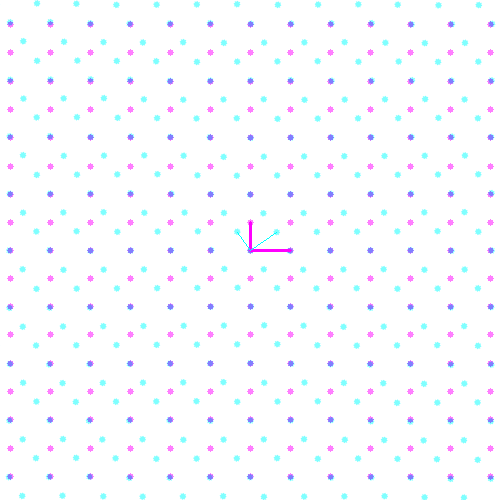



Substrate(110)//Target(110), θ=74.3°, overlapping=837px


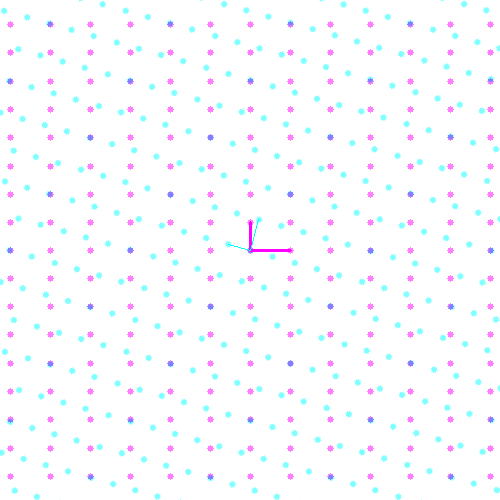

In [ ]:
angles = [35.2, 74.3]
out = {}
base_index = (1,1,0)
on_index = (1,1,0)
substrate = crystall["Ge"]
target = crystall["FeGe"]
head = f"Substrate({base_index[0]}{base_index[1]}{base_index[2]})//Target({on_index[0]}{on_index[1]}{on_index[2]})"
base = generate_lattice_image(substrate, base_index)
on = generate_lattice_image(target, on_index)

for angle in angles:
  trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
  on_rot = cv2.warpAffine(on, trans, (W, H))
  value = np.sum((on_rot*base)[H//4:H//4*3,W//4:W//4*3])
  trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
  on_rot = cv2.warpAffine(on, trans, (W, H))
  print(f"\n{head}, θ={angle:.1f}°, overlapping={value:.0f}px")
  base_show = cv2.cvtColor((base*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
  on_rot_show = cv2.cvtColor((on_rot*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

  base_show[:,:,0] = 0
  base_show[:,:,2] = 0
  on_rot_show[:,:,0] = 0
  on_rot_show[:,:,1] = 0
  show_image = (255-base_show/2-on_rot_show/2)[H//4:H//4*3,W//4:W//4*3]

  h, w, _ = show_image.shape

  s_a, s_b, s_angle = substrate.index_to_parallelogram(base_index[0], base_index[1], base_index[2])
  t_a, t_b, t_angle = target.index_to_parallelogram(on_index[0], on_index[1], on_index[2])

  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(s_a*np.sin(-0/180*np.pi)*a), h//2-int(s_a*np.cos(-0/180*np.pi)*a)),
      color=(255, 0, 255),
      thickness=2,
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(s_b*np.sin((s_angle-0)/180*np.pi)*a), h//2-int(s_b*np.cos((s_angle-0)/180*np.pi)*a)),
      color=(255, 0, 255),
      thickness=2,
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(t_a*np.sin(-angle/180*np.pi)*a), h//2-int(t_a*np.cos(-angle/180*np.pi)*a)),
      color=(255, 255, 0),
  )
  cv2.line(
      show_image,
      pt1=(w//2, h//2),
      pt2=(w//2+int(t_b*np.sin((t_angle-angle)/180*np.pi)*a), h//2-int(t_b*np.cos((t_angle-angle)/180*np.pi)*a)),
      color=(255, 255, 0),
  )

  cv2_imshow(show_image)
  print("")

In [ ]:
calc_mismatch(crystall["Ge"], (1,1,0), (4, -1), (-2, -1), crystall["FeGe"], (1,1,0), (3, 3), (1, -2))

S	a	1b	2a	2b	Δa	Δb
335	24.00	13.86	24.15	13.95	0.62	0.62


# 9.3°

In [ ]:
crystall["Ge"].axis_length((1,1,0),3,2)

23.328531629744724

In [ ]:
crystall["FeGe"].axis_length((1,0,0),3,4)

23.242

In [ ]:
crystall["Ge"].axis_length((1,1,0),2,2)

19.599886938449416

In [ ]:
crystall["FeGe"].axis_length((1,0,0),3,3)

19.721490970005284

In [ ]:
s_1 = 23.328531629744724 * 19.599886938449416
s_2 = 23.242 * 19.721490970005284
(s_1+s_2)/2

457.80173775395025

In [ ]:
calc_mismatch(crystall["FeGe"].axis_length((1,0,0),3,4), crystall["Ge"].axis_length((1,1,0),3,2))

Ge 23.329
Target 23.242
-0.37


In [ ]:
calc_mismatch(crystall["FeGe"].axis_length((1,0,0),3,3), crystall["Ge"].axis_length((1,1,0),2,2))

Ge 19.600
Target 19.721
0.62


# 35.4°

In [ ]:
calc_mismatch(crystall["FeGe"].axis_length((1,0,0),0,2), crystall["Ge"].axis_length((1,1,0),1,1))

Ge 9.800
Target 9.297
-5.13


In [ ]:
calc_mismatch(crystall["FeGe"].axis_length((1,0,0),3,0), crystall["Ge"].axis_length((1,1,0),2,-1))

Ge 13.859
Target 13.945
0.62


In [ ]:
s_1 = 9.800 * 13.859
s_2 = 9.297 * 13.945
(s_1+s_2)/2

132.73243250000002

# 他

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(110)//Target(011), θ=2.0°, overlapping=921px


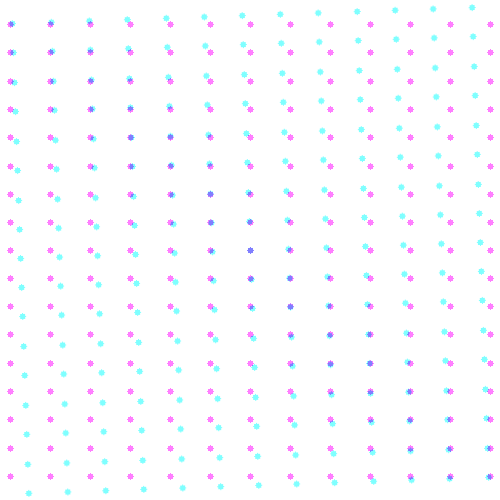



Substrate(110)//Target(101), θ=2.0°, overlapping=921px


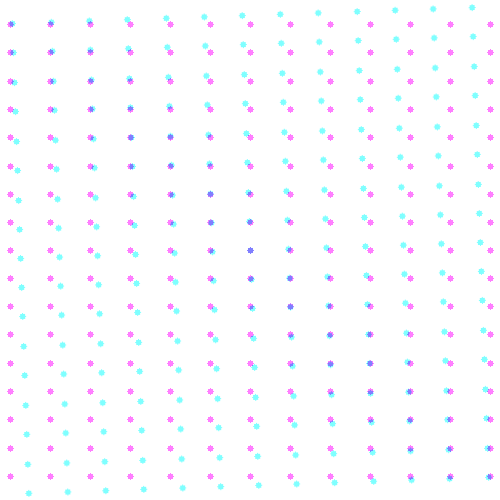

In [ ]:
simulate_matching(crystall["Ge"], crystall["FeGe2"])

In [ ]:
l_ge ,l = crystall["Ge"].axis_length((1,1,0),0,1), crystall["PdGe"].axis_length((1,0,0),0,1)
calc_mismatch(l, l_ge)

Ge 8.002
Target 7.678
-4.05


  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(100), θ=89.0°, overlapping=1054px


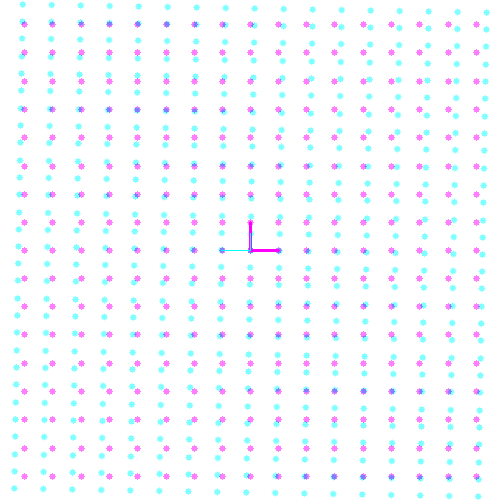



Substrate(100)//Target(010), θ=13.0°, overlapping=675px


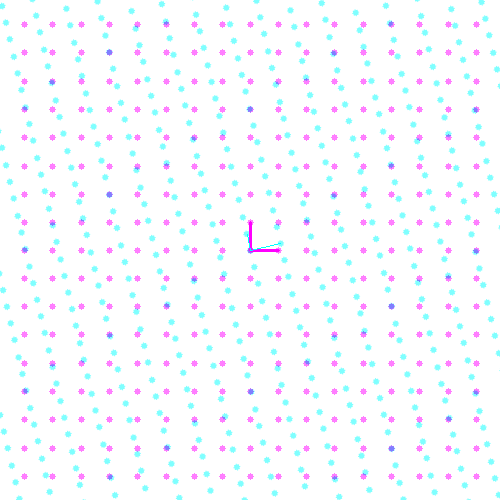



Substrate(100)//Target(001), θ=88.0°, overlapping=365px


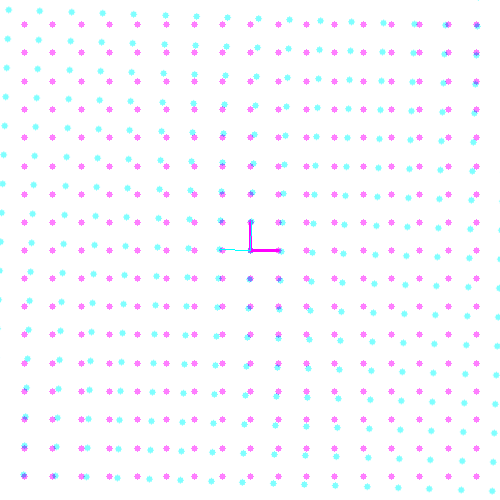



Substrate(100)//Target(110), θ=0.0°, overlapping=713px


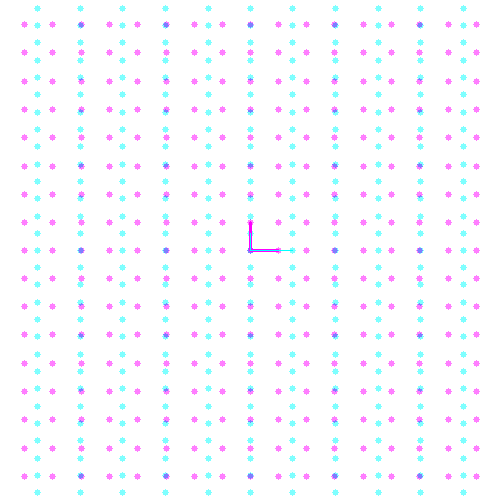



Substrate(100)//Target(011), θ=65.0°, overlapping=537px


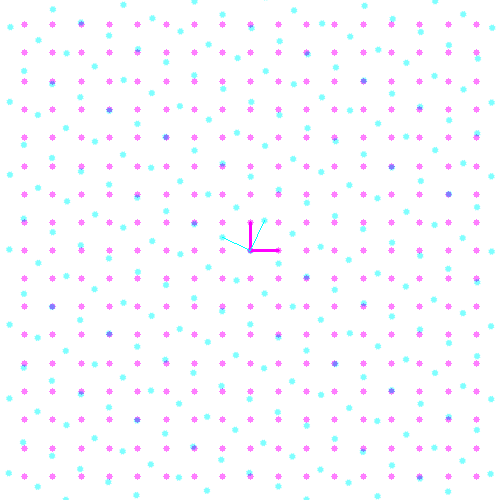



Substrate(100)//Target(101), θ=0.0°, overlapping=431px


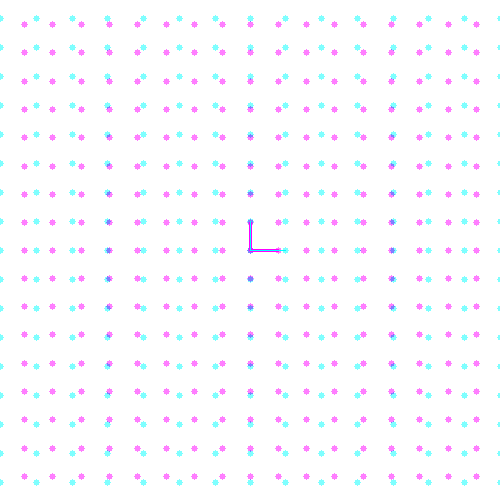



Substrate(100)//Target(111), θ=89.0°, overlapping=422px


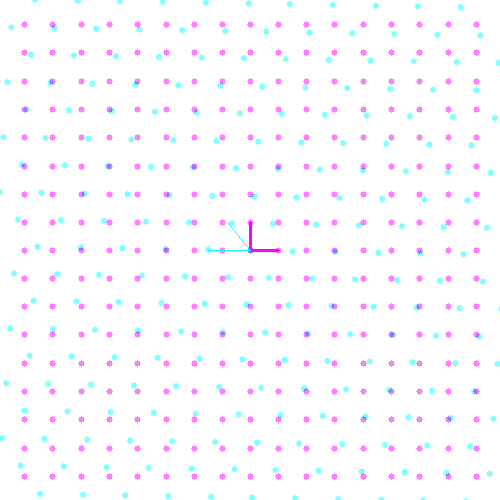



Substrate(110)//Target(100), θ=0.0°, overlapping=819px


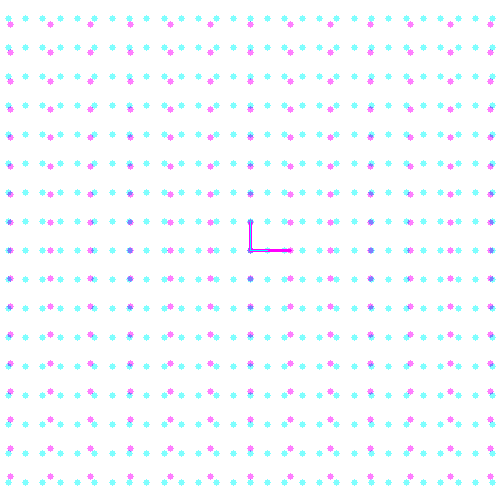



Substrate(110)//Target(010), θ=83.0°, overlapping=667px


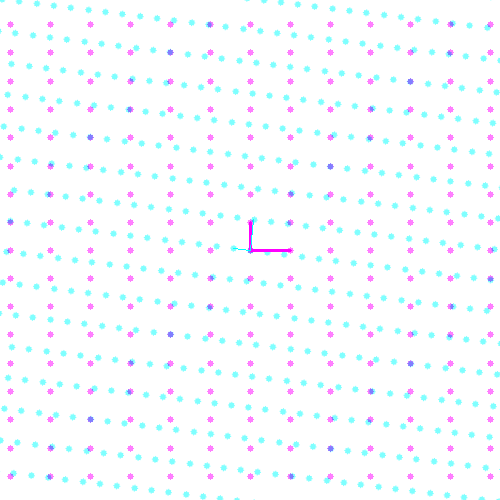



Substrate(110)//Target(001), θ=89.0°, overlapping=373px


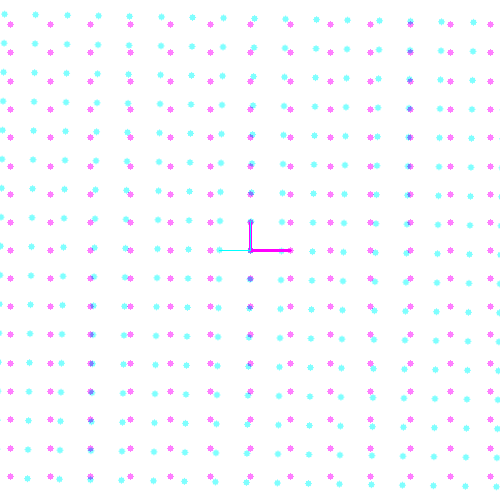



Substrate(110)//Target(110), θ=51.0°, overlapping=567px


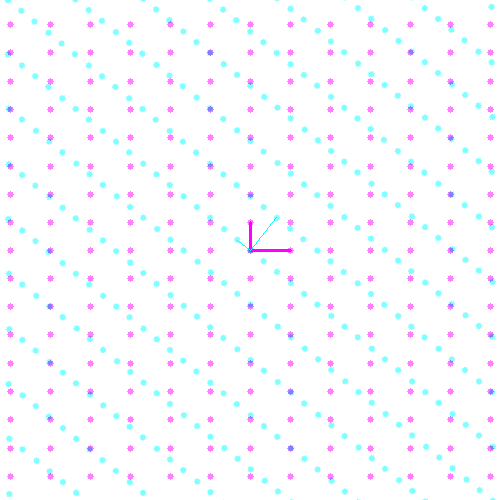



Substrate(110)//Target(011), θ=78.0°, overlapping=663px


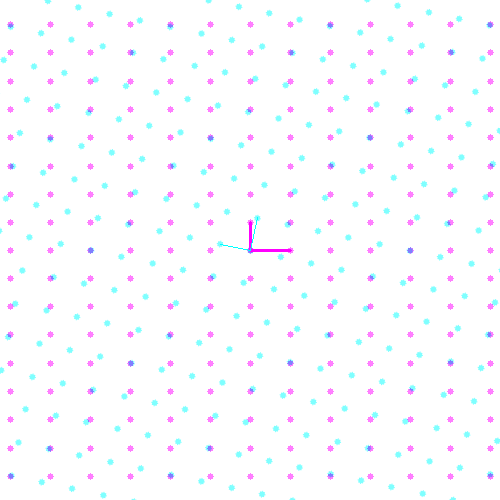



Substrate(110)//Target(101), θ=3.0°, overlapping=493px


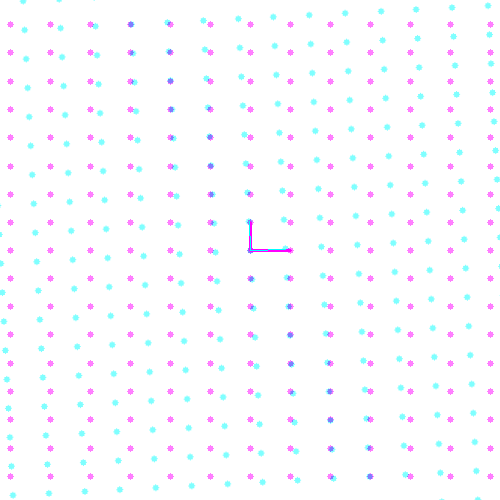



Substrate(110)//Target(111), θ=13.0°, overlapping=404px


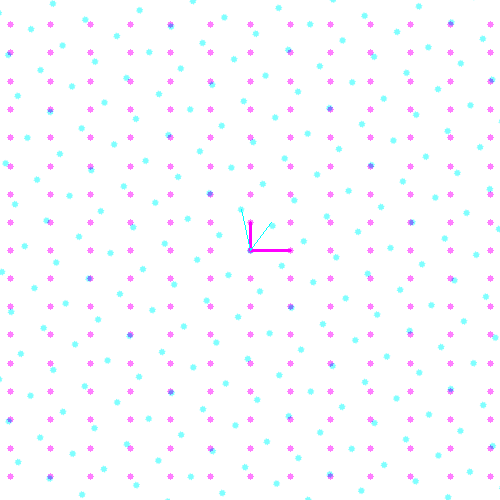



Substrate(111)//Target(100), θ=60.0°, overlapping=950px


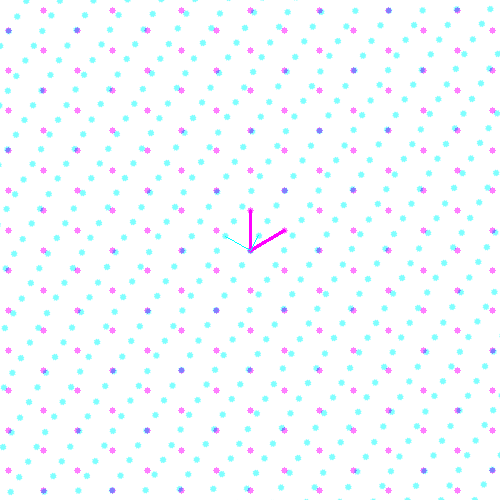



Substrate(111)//Target(010), θ=90.0°, overlapping=923px


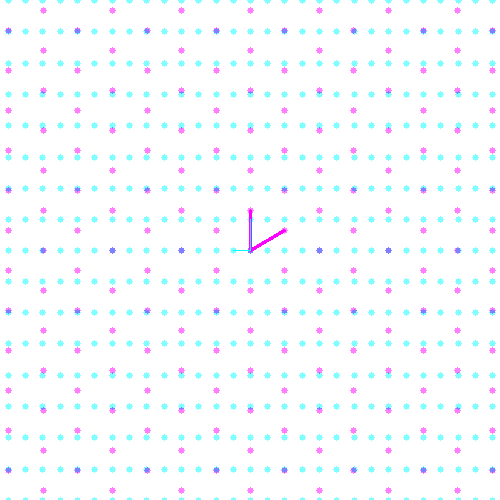



Substrate(111)//Target(001), θ=76.0°, overlapping=391px


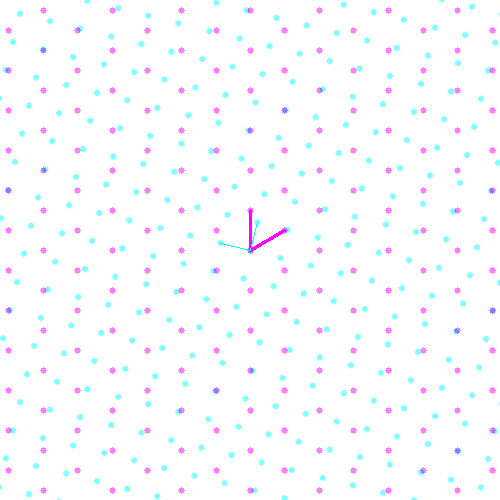



Substrate(111)//Target(110), θ=30.0°, overlapping=618px


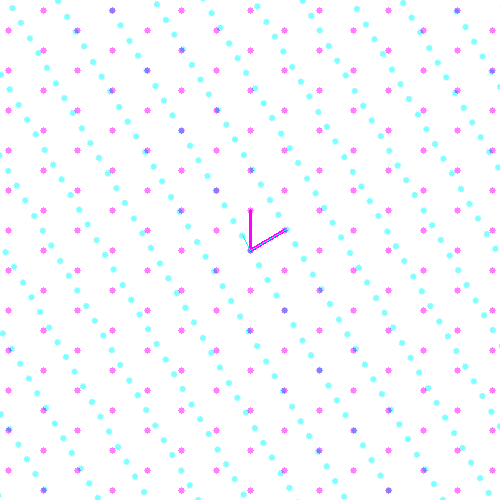



Substrate(111)//Target(011), θ=0.0°, overlapping=449px


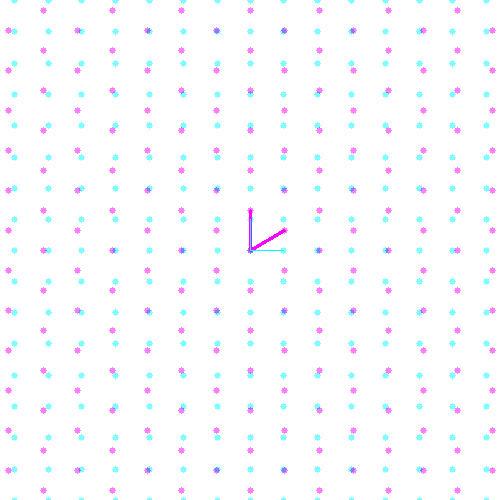



Substrate(111)//Target(101), θ=60.0°, overlapping=421px


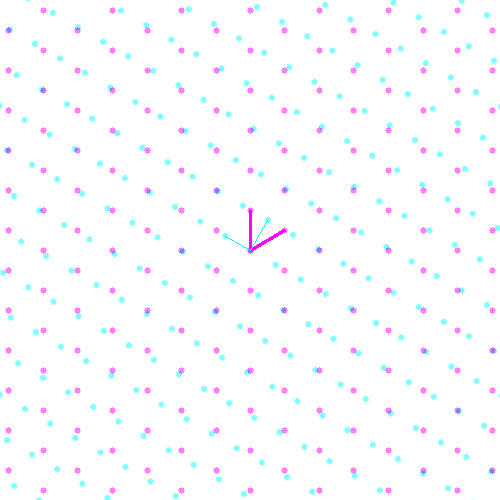



Substrate(111)//Target(111), θ=54.0°, overlapping=693px


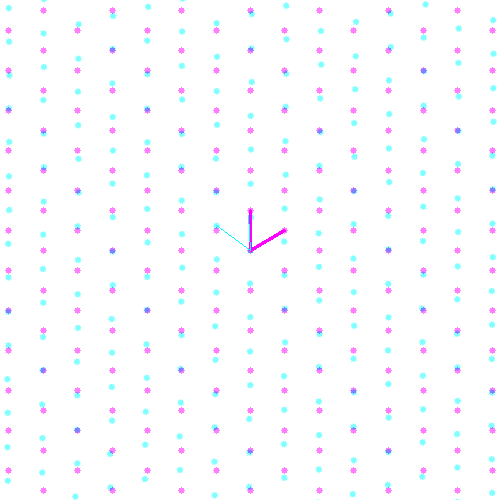

In [ ]:
simulate_matching(crystall["Ge"], crystall["PdGe"], thresh=0)

In [ ]:
simulate_matching(crystall["Ge"], crystall["Pd2Ge"])

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(100), θ=0.0°, overlapping=895px


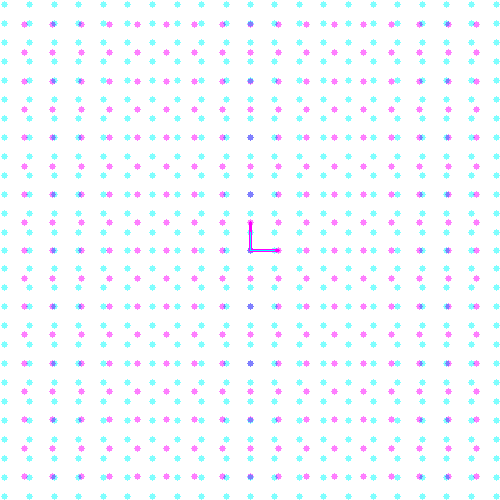



Substrate(100)//Target(010), θ=0.0°, overlapping=811px


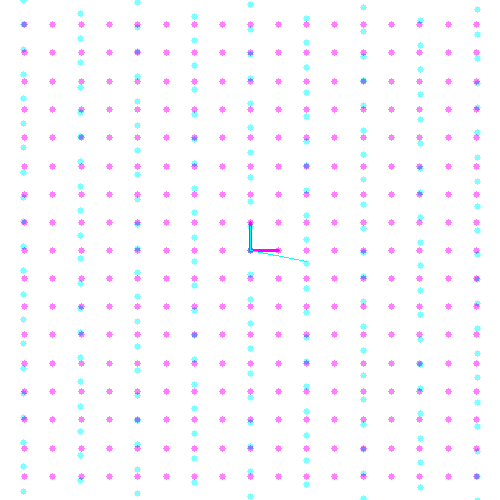



Substrate(100)//Target(001), θ=0.0°, overlapping=1065px


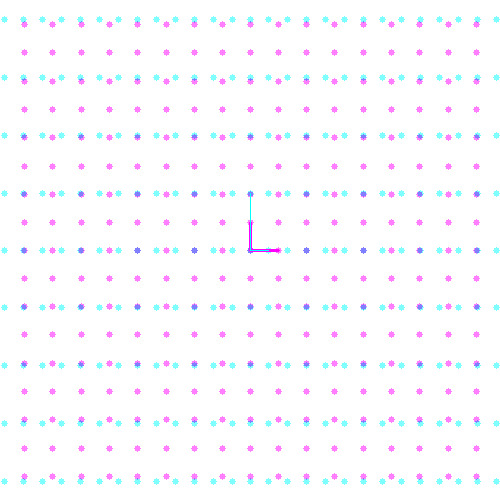



Substrate(110)//Target(111), θ=62.0°, overlapping=873px


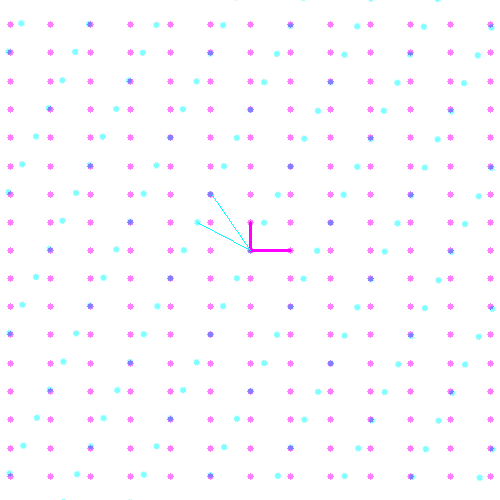

In [ ]:
simulate_matching(crystall["Ge"], crystall["CoGe_1"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(111), θ=0.0°, overlapping=1493px


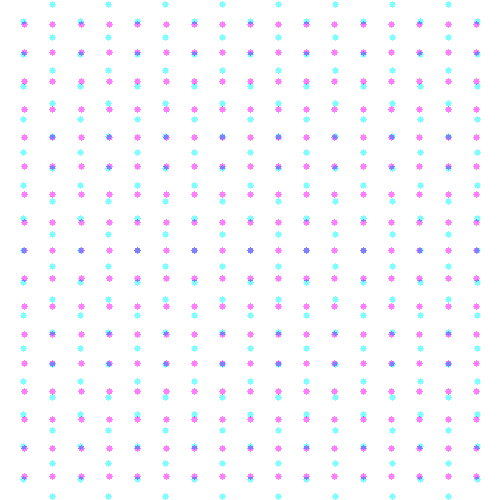



Substrate(110)//Target(100), θ=35.0°, overlapping=1241px


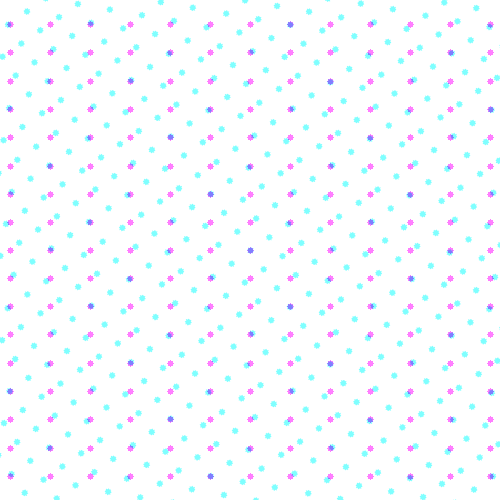



Substrate(110)//Target(010), θ=35.0°, overlapping=1241px


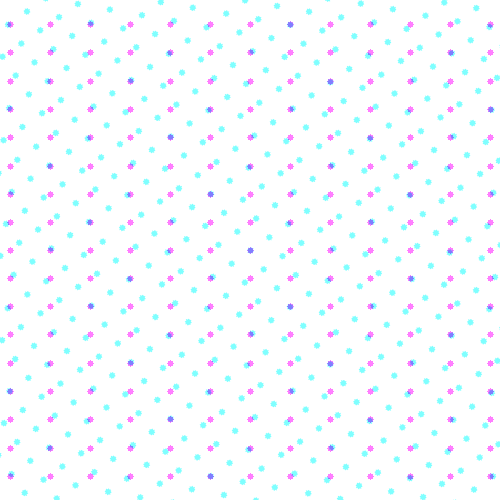



Substrate(110)//Target(001), θ=35.0°, overlapping=1241px


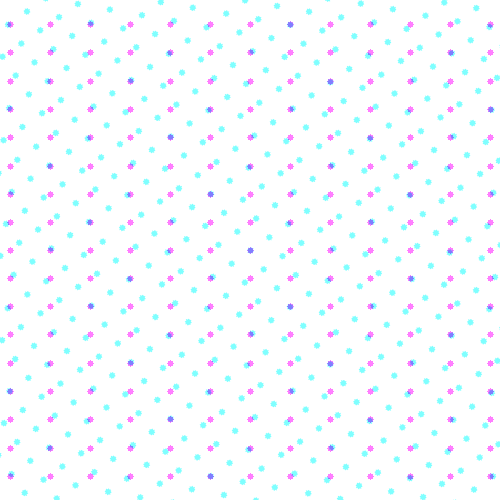



Substrate(110)//Target(110), θ=35.0°, overlapping=2423px


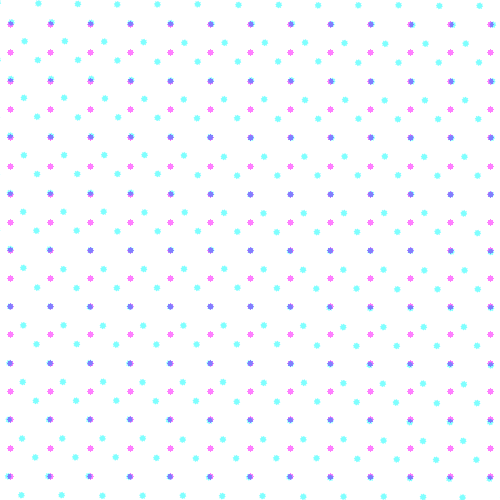



Substrate(110)//Target(011), θ=35.0°, overlapping=2423px


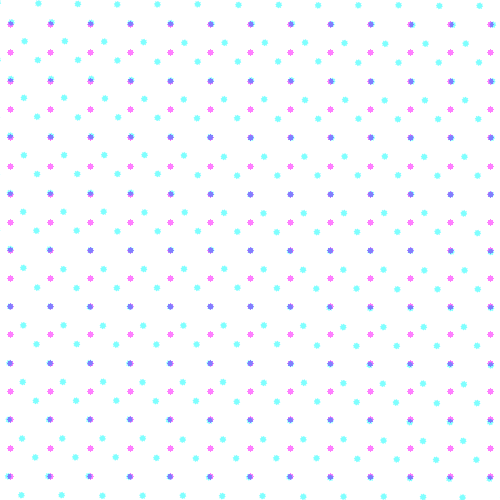



Substrate(110)//Target(101), θ=35.0°, overlapping=2423px


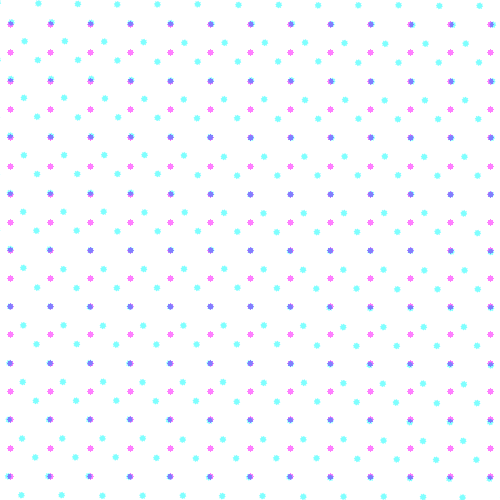



Substrate(110)//Target(111), θ=30.0°, overlapping=825px


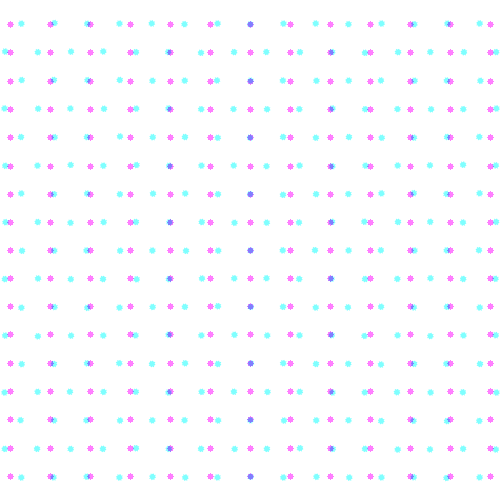

In [ ]:
simulate_matching(crystall["Ge"], crystall["CoGe_2"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(100), θ=0.0°, overlapping=1637px


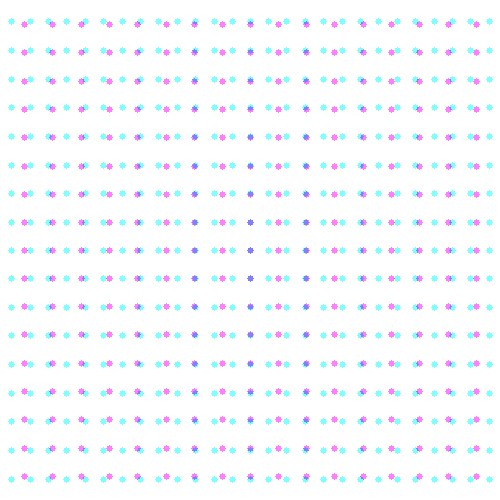



Substrate(100)//Target(001), θ=0.0°, overlapping=1009px


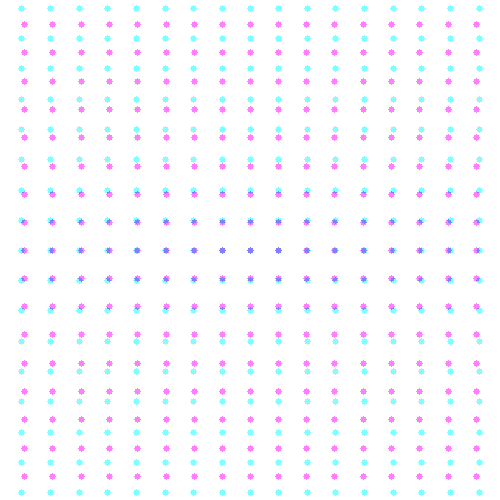



Substrate(100)//Target(101), θ=0.0°, overlapping=949px


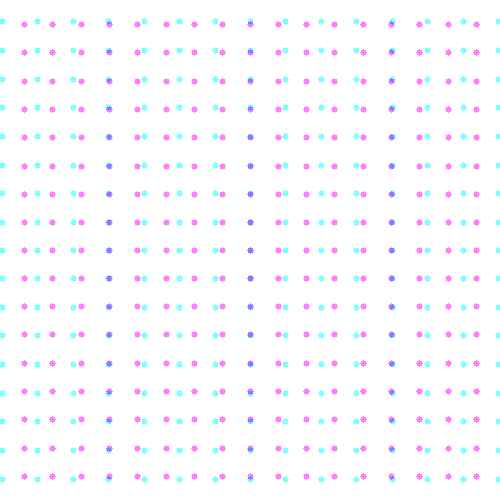



Substrate(110)//Target(100), θ=0.0°, overlapping=1673px


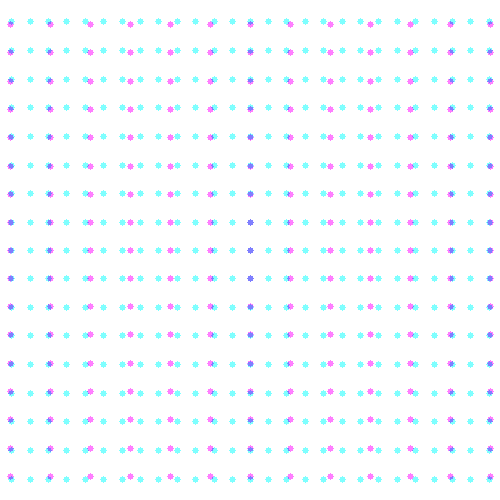



Substrate(110)//Target(001), θ=90.0°, overlapping=1431px


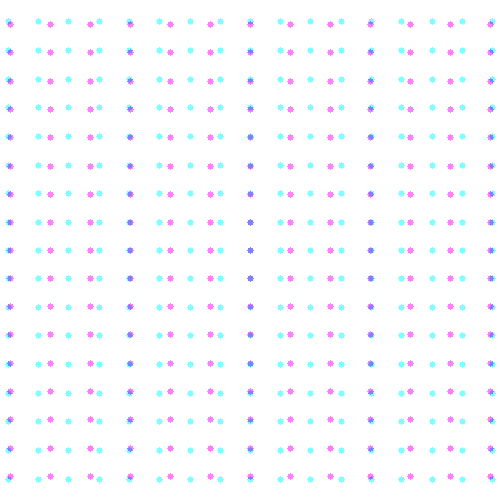



Substrate(111)//Target(011), θ=0.0°, overlapping=1005px


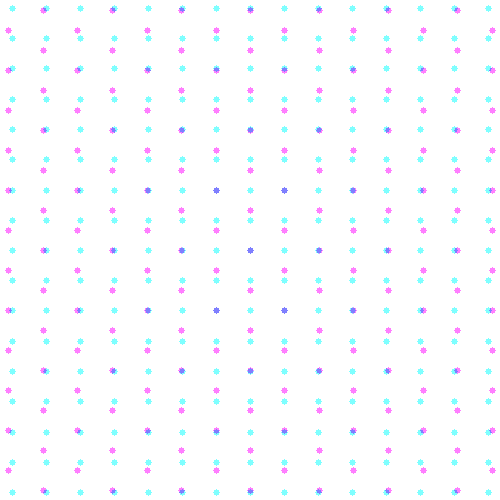

In [ ]:
simulate_matching(crystall["Ge"], crystall["PtGe"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(100), θ=45.0°, overlapping=1113px


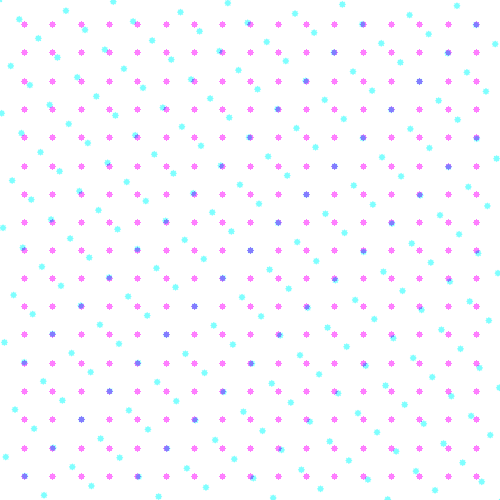



Substrate(100)//Target(010), θ=45.0°, overlapping=1113px


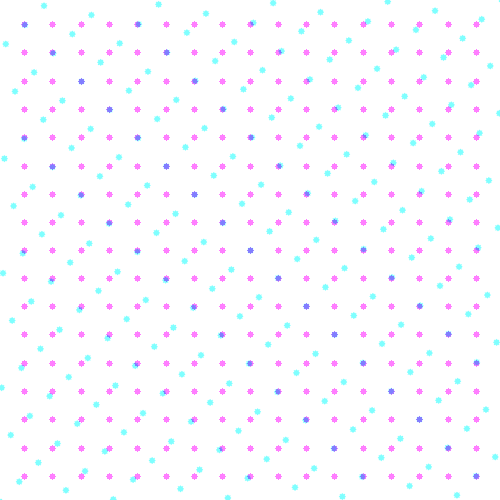



Substrate(100)//Target(001), θ=0.0°, overlapping=841px


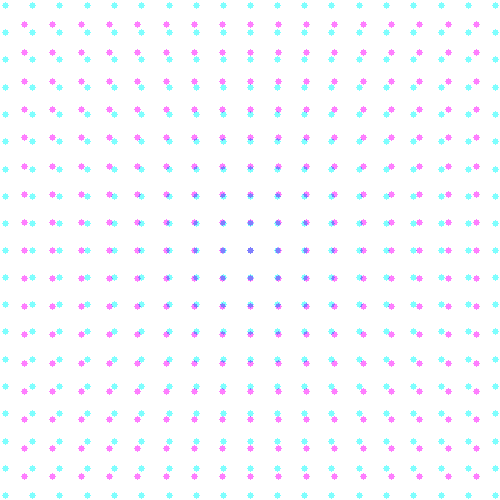



Substrate(100)//Target(110), θ=45.0°, overlapping=1331px


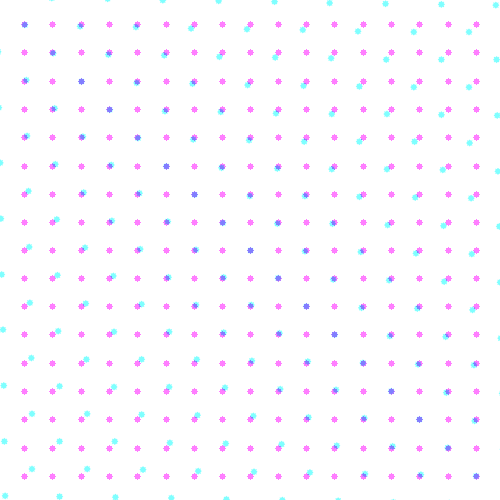



Substrate(110)//Target(100), θ=0.0°, overlapping=1711px


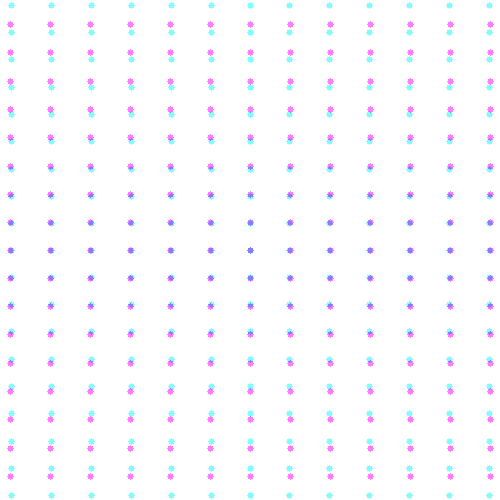



Substrate(110)//Target(010), θ=90.0°, overlapping=1711px


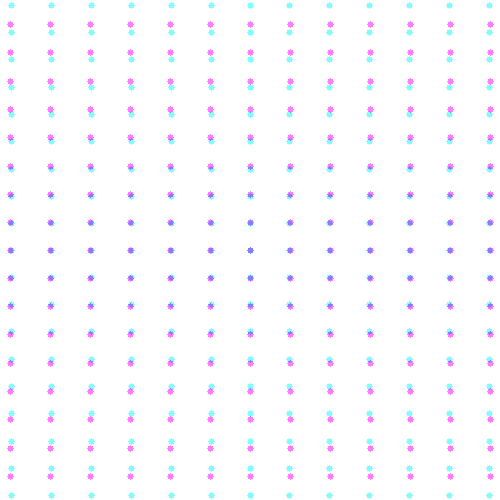



Substrate(110)//Target(110), θ=90.0°, overlapping=815px


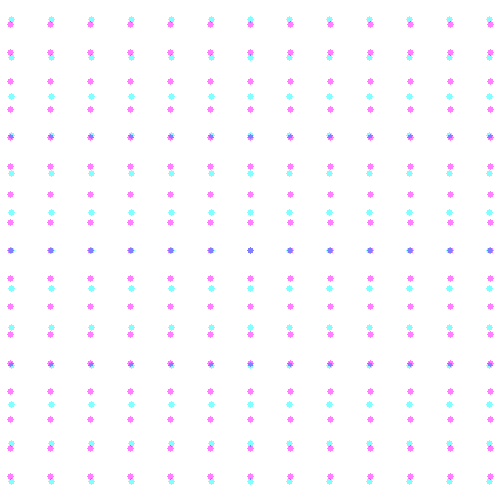

In [ ]:
simulate_matching(crystall["Ge"], crystall["Pt3Ge"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(011), θ=4.0°, overlapping=990px


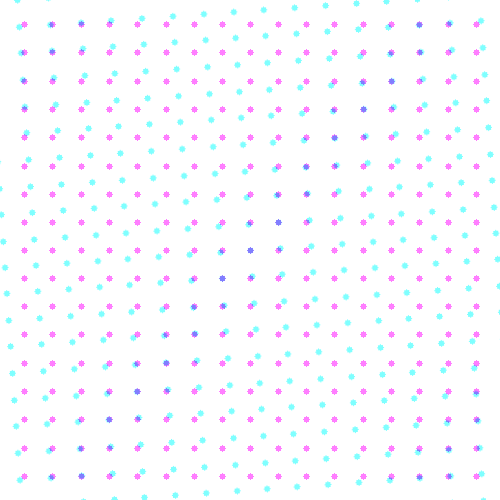



Substrate(100)//Target(111), θ=0.0°, overlapping=953px


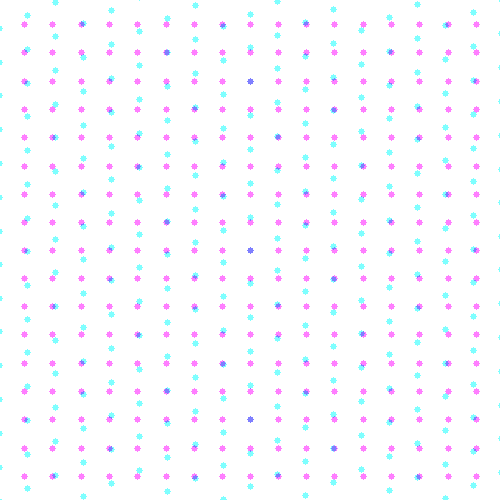



Substrate(110)//Target(100), θ=55.0°, overlapping=919px


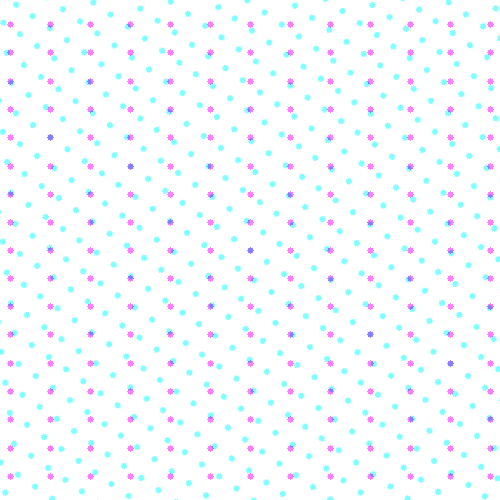



Substrate(110)//Target(010), θ=0.0°, overlapping=839px


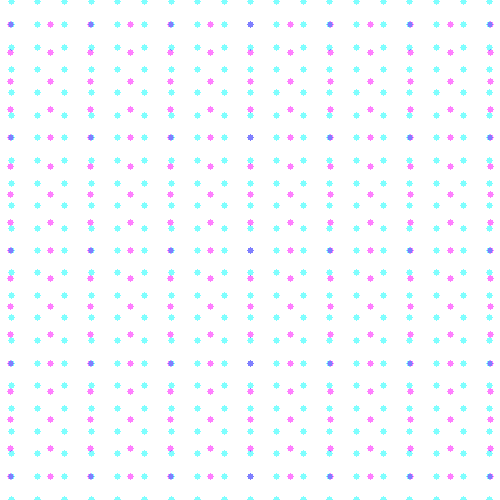



Substrate(110)//Target(001), θ=3.0°, overlapping=899px


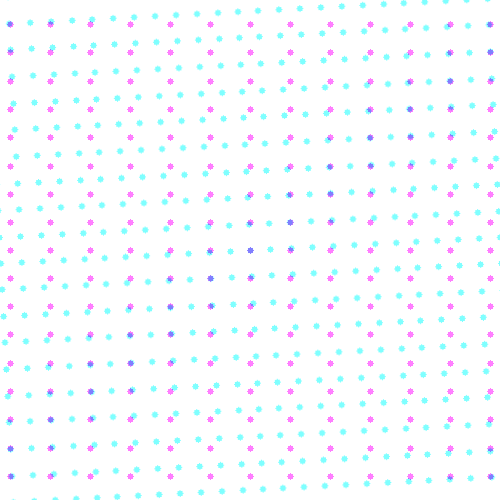



Substrate(111)//Target(101), θ=0.0°, overlapping=1327px


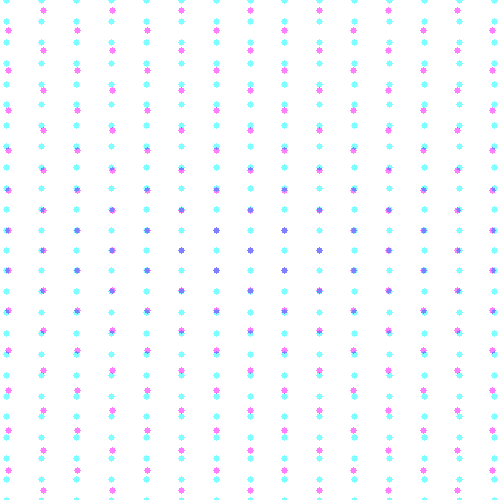

In [ ]:
simulate_matching(crystall["Ge"], crystall["Cu3Ge"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(100), θ=88.0°, overlapping=1382px


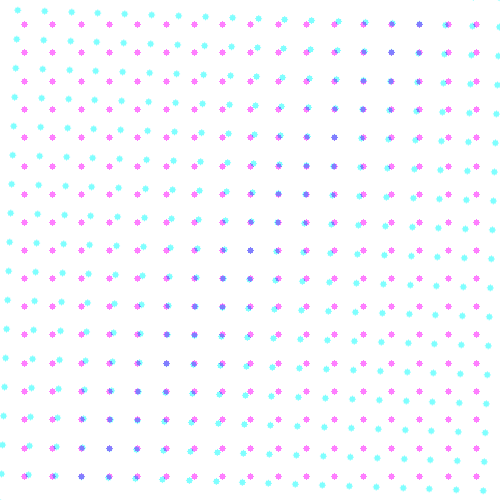



Substrate(100)//Target(010), θ=0.0°, overlapping=991px


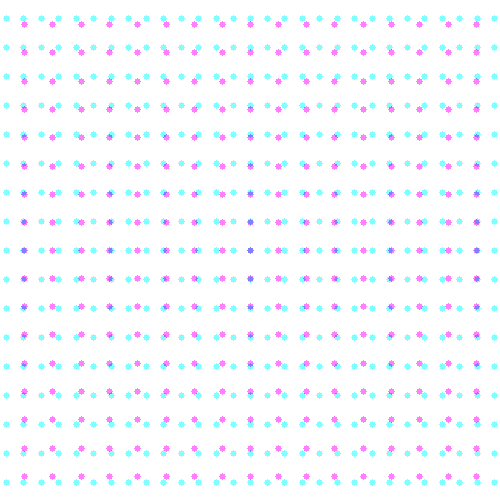



Substrate(100)//Target(011), θ=45.0°, overlapping=988px


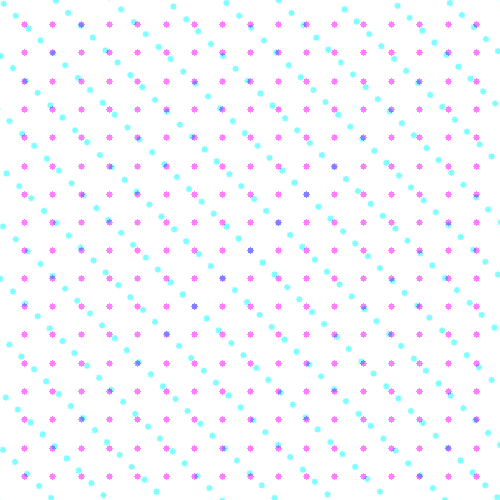



Substrate(110)//Target(100), θ=90.0°, overlapping=1153px


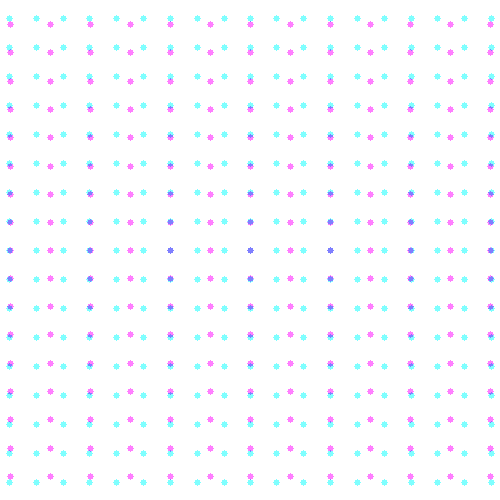



Substrate(110)//Target(001), θ=0.0°, overlapping=979px


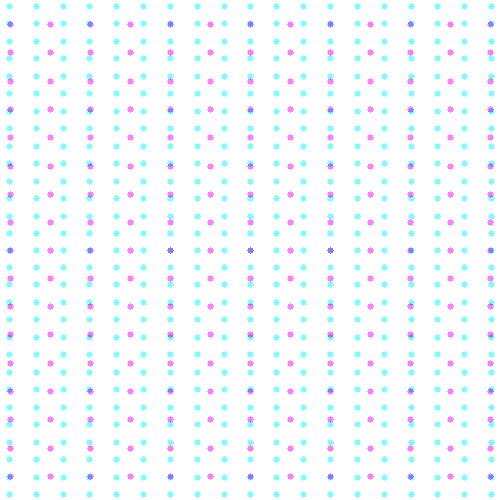



Substrate(110)//Target(011), θ=0.0°, overlapping=1349px


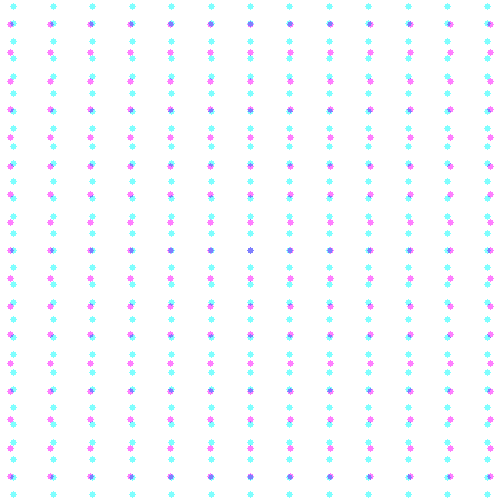



Substrate(111)//Target(010), θ=60.0°, overlapping=879px


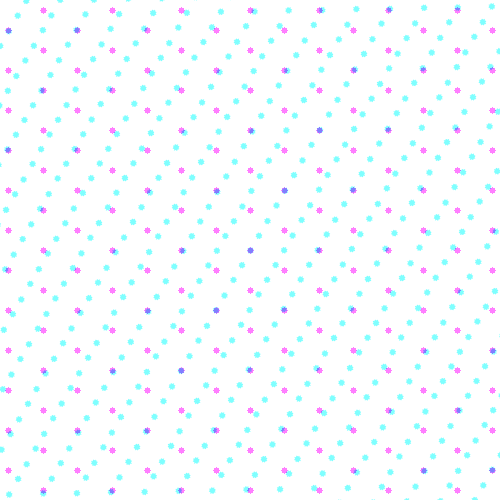



Substrate(111)//Target(001), θ=90.0°, overlapping=1059px


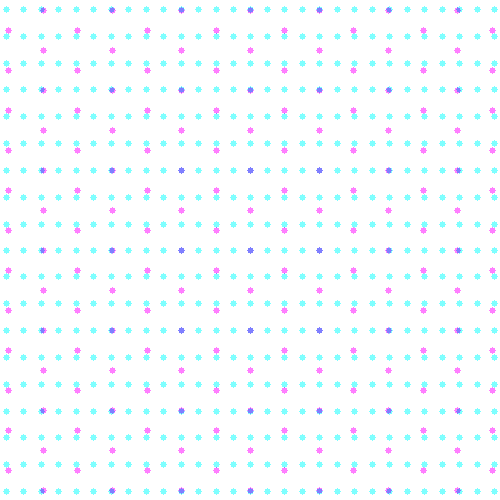



Substrate(111)//Target(011), θ=30.0°, overlapping=1674px


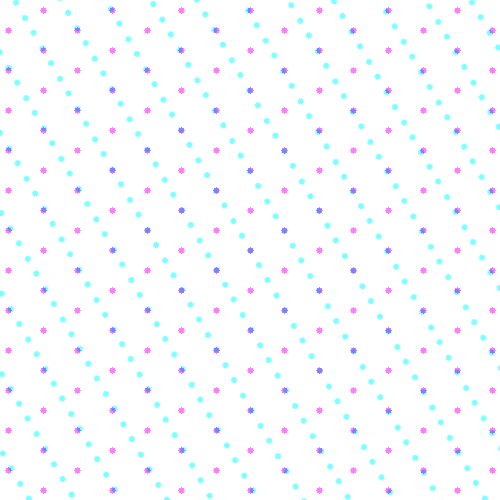

In [ ]:
simulate_matching(crystall["Ge"], crystall["NiGe"])

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(010), θ=27.0°, overlapping=618px


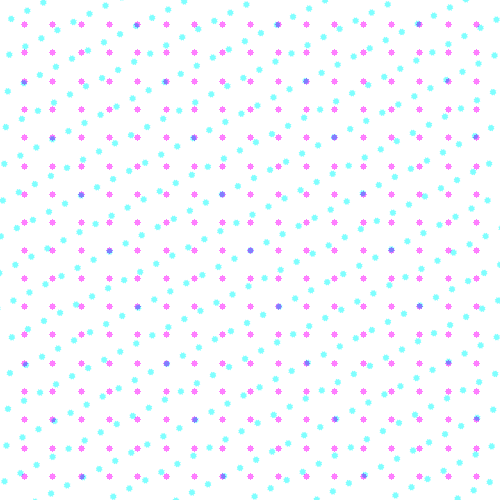



Substrate(100)//Target(001), θ=0.0°, overlapping=877px


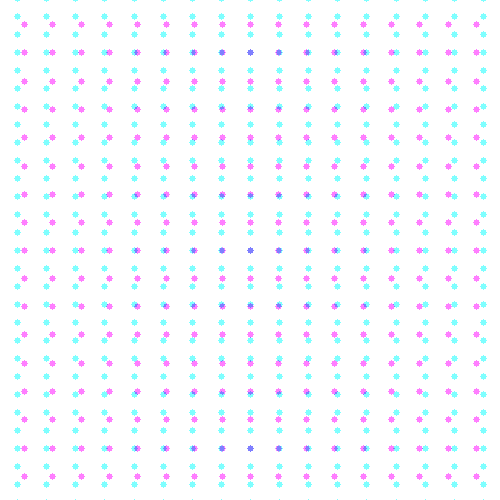



Substrate(100)//Target(111), θ=55.0°, overlapping=868px


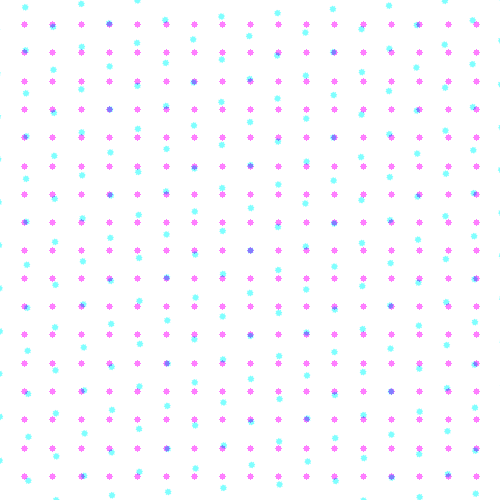



Substrate(110)//Target(001), θ=89.0°, overlapping=744px


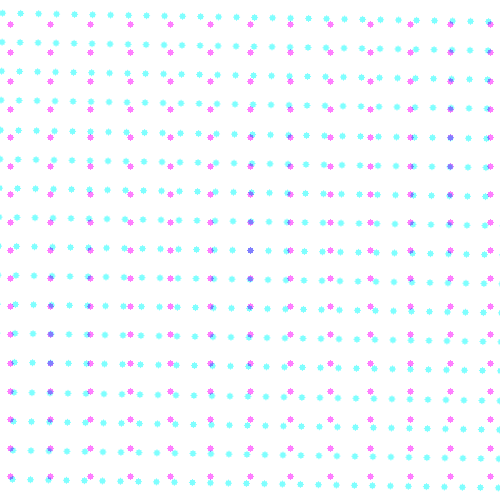



Substrate(110)//Target(110), θ=78.0°, overlapping=646px


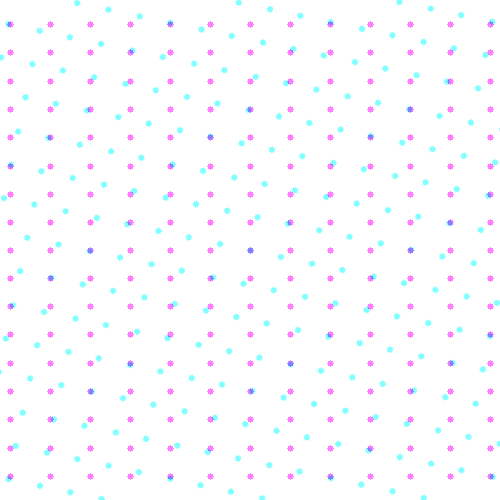



Substrate(111)//Target(110), θ=0.0°, overlapping=779px


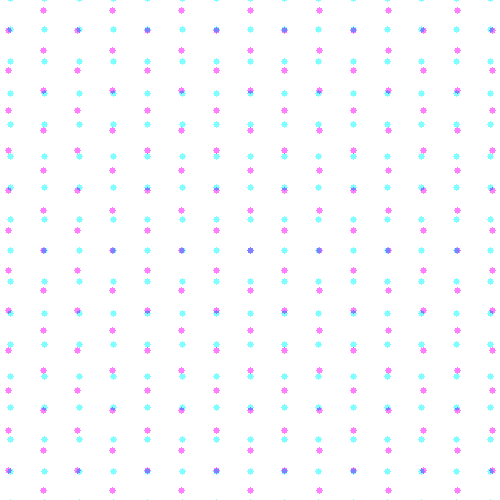



Substrate(111)//Target(111), θ=60.0°, overlapping=652px


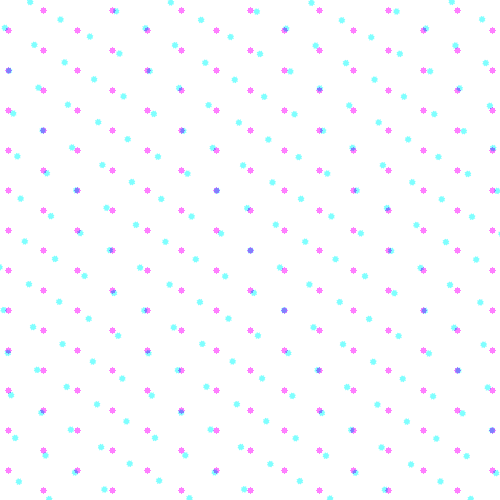

In [ ]:
simulate_matching(crystall["Ge"], crystall["PdGe"], thresh=600)

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(010), θ=55.0°, overlapping=612px


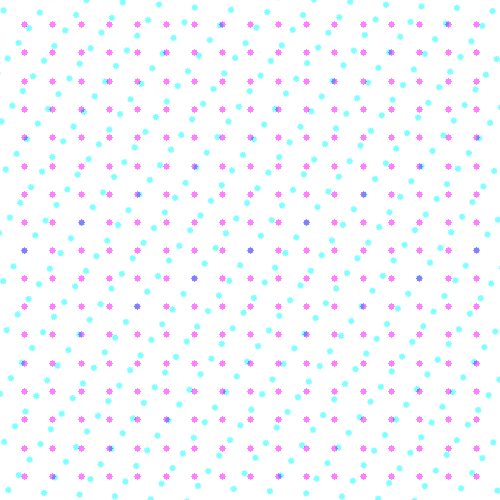



Substrate(100)//Target(001), θ=1.0°, overlapping=1042px


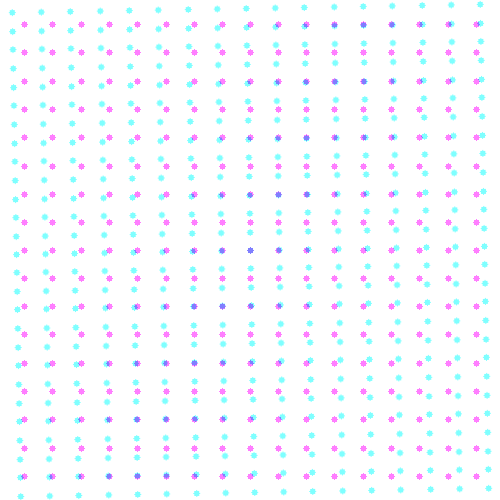



Substrate(100)//Target(011), θ=49.0°, overlapping=791px


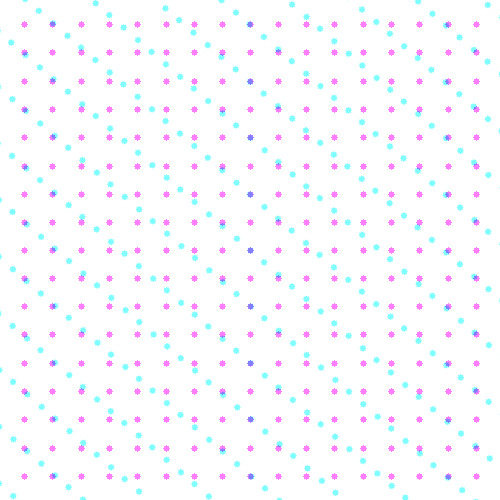



Substrate(100)//Target(111), θ=55.0°, overlapping=858px


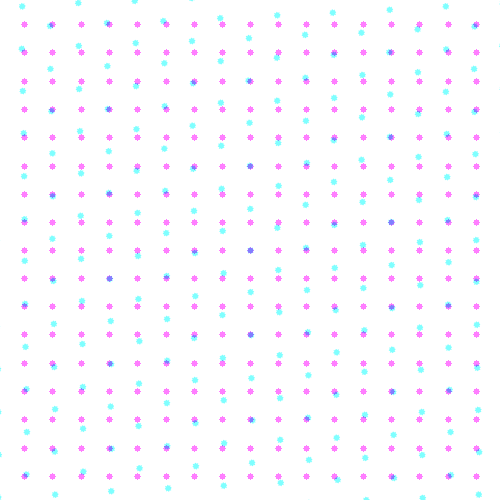



Substrate(110)//Target(001), θ=87.0°, overlapping=712px


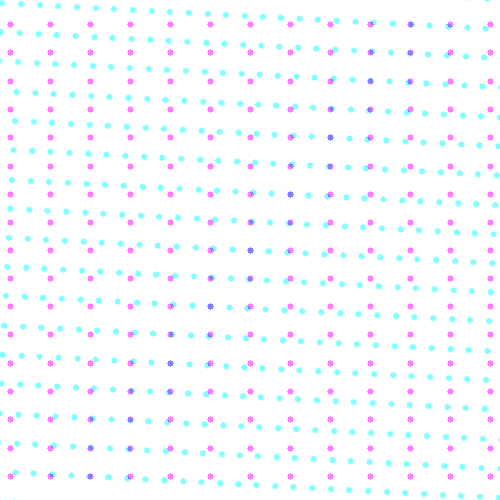



Substrate(110)//Target(110), θ=6.0°, overlapping=627px


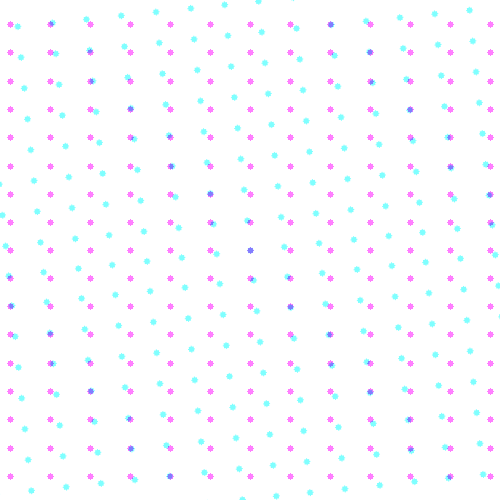



Substrate(111)//Target(110), θ=60.0°, overlapping=889px


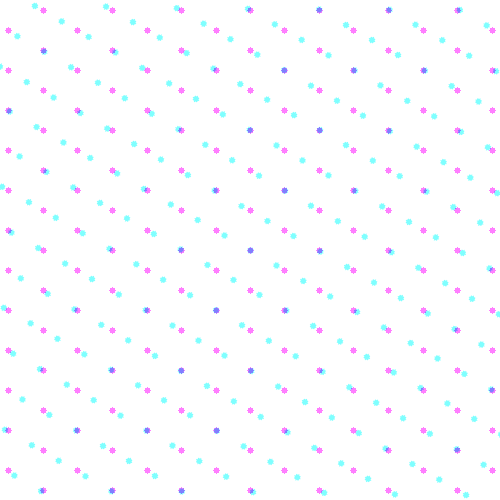



Substrate(111)//Target(111), θ=0.0°, overlapping=797px


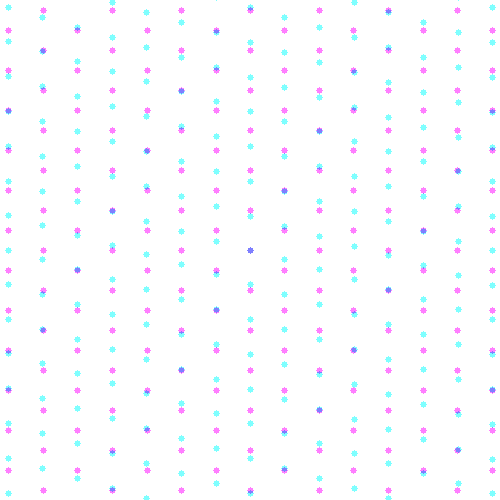

In [ ]:
simulate_matching(crystall["Ge"], crystall["PtGe"], thresh=600)

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(100)//Target(001), θ=73.0°, overlapping=828px


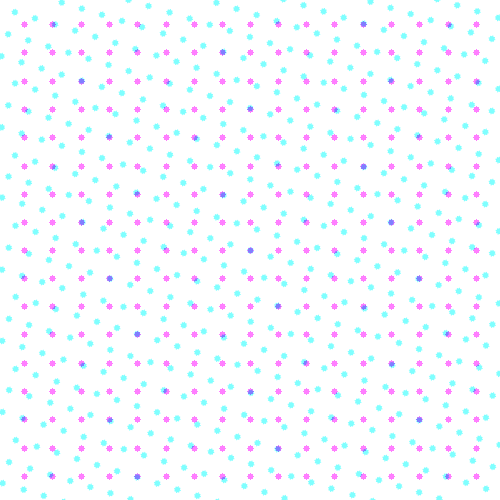



Substrate(100)//Target(110), θ=85.0°, overlapping=824px


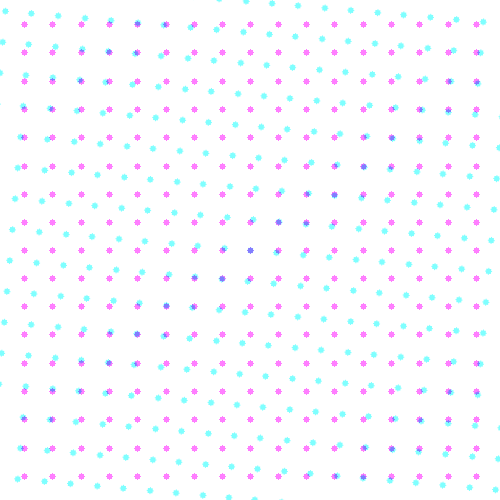



Substrate(100)//Target(111), θ=25.0°, overlapping=1147px


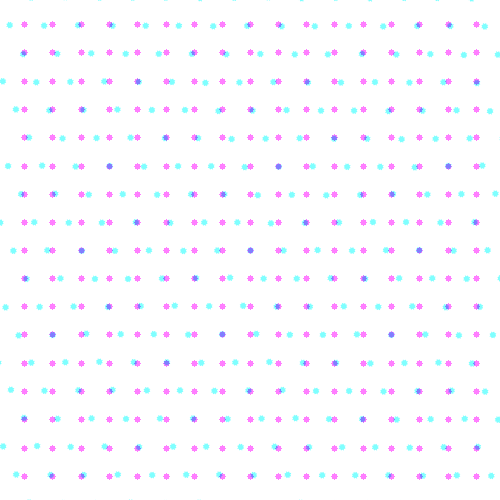



Substrate(110)//Target(100), θ=35.0°, overlapping=836px


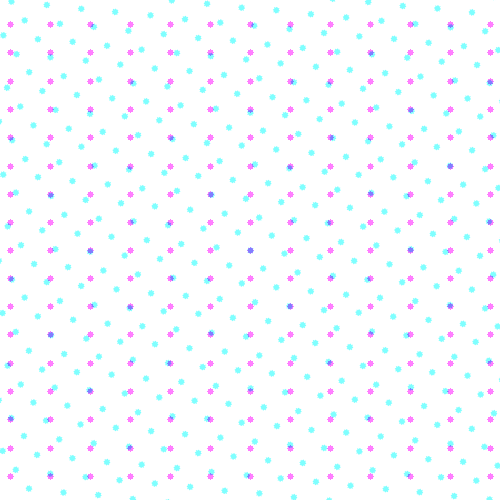



Substrate(110)//Target(010), θ=90.0°, overlapping=809px


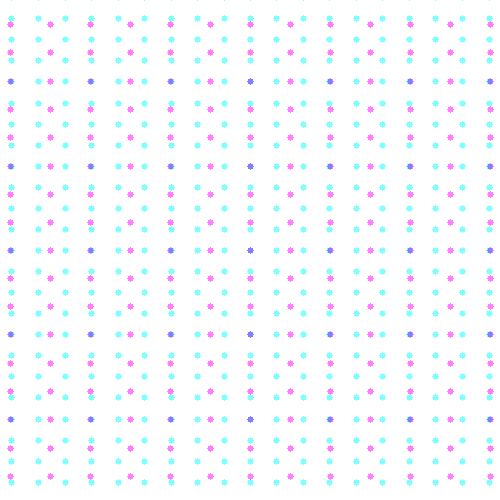



Substrate(110)//Target(001), θ=55.0°, overlapping=1034px


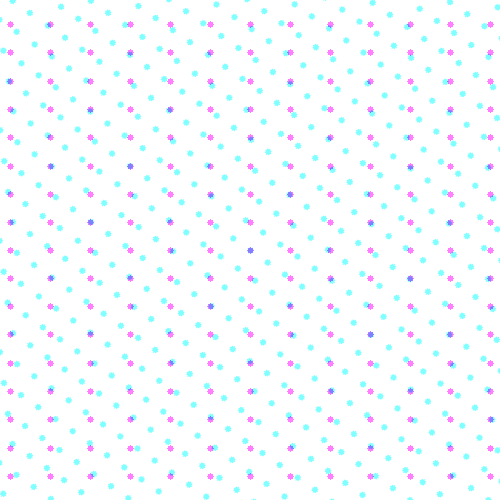



Substrate(110)//Target(110), θ=50.0°, overlapping=660px


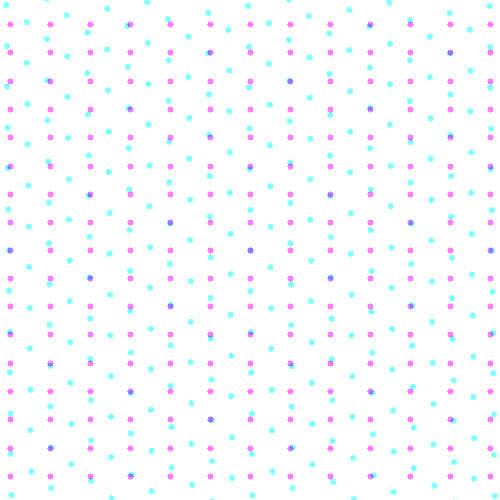



Substrate(110)//Target(011), θ=31.0°, overlapping=638px


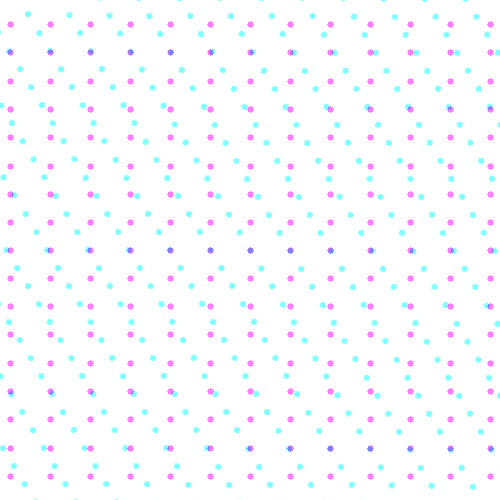



Substrate(110)//Target(101), θ=35.0°, overlapping=771px


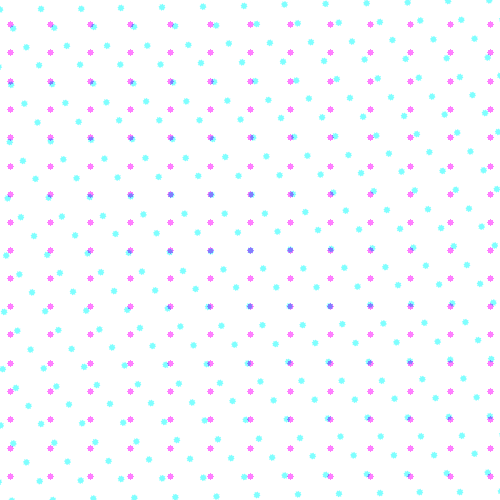



Substrate(110)//Target(111), θ=25.0°, overlapping=875px


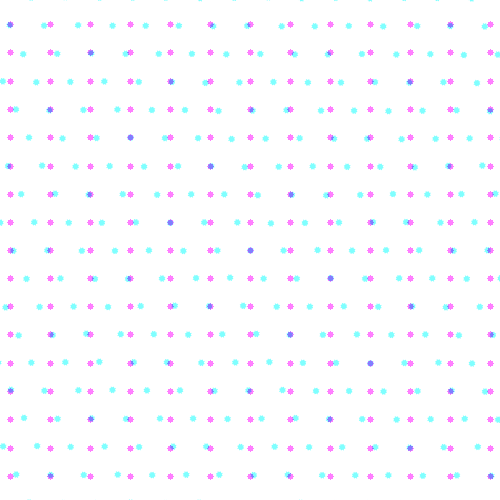



Substrate(111)//Target(100), θ=90.0°, overlapping=815px


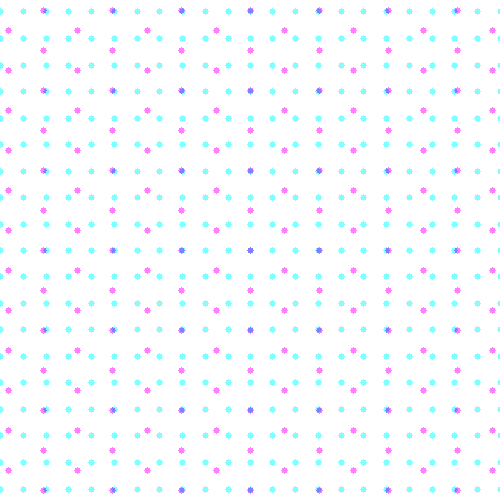



Substrate(111)//Target(011), θ=60.0°, overlapping=1034px


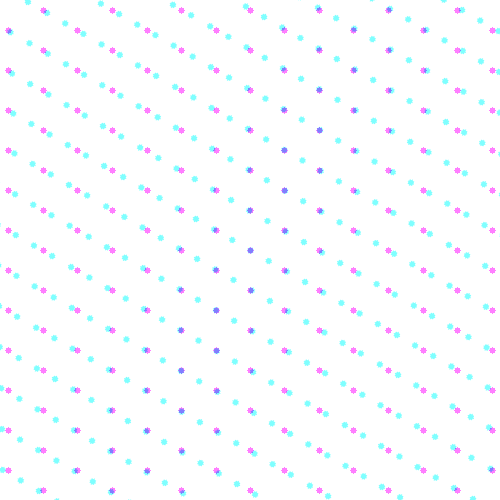



Substrate(111)//Target(101), θ=0.0°, overlapping=667px


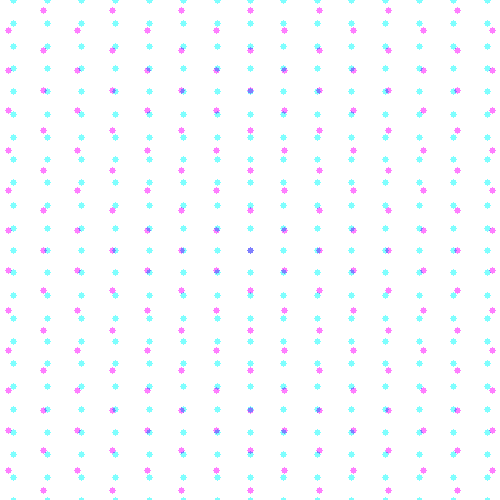

In [ ]:
simulate_matching(crystall["Ge"], crystall["Cu3Ge"], thresh=600)

  0%|          | 0/1911 [00:00<?, ?it/s]


Substrate(111)//Target(100), θ=90.0°, overlapping=677px


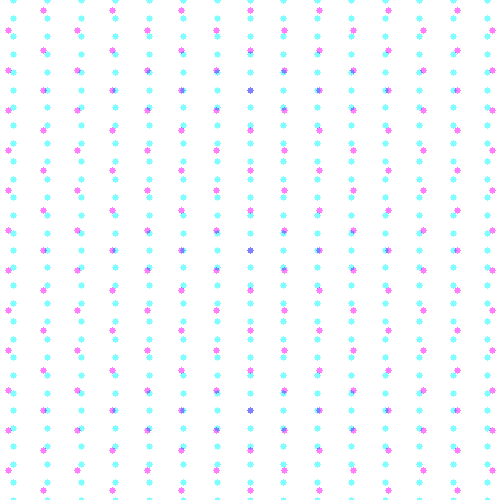



Substrate(111)//Target(010), θ=0.0°, overlapping=677px


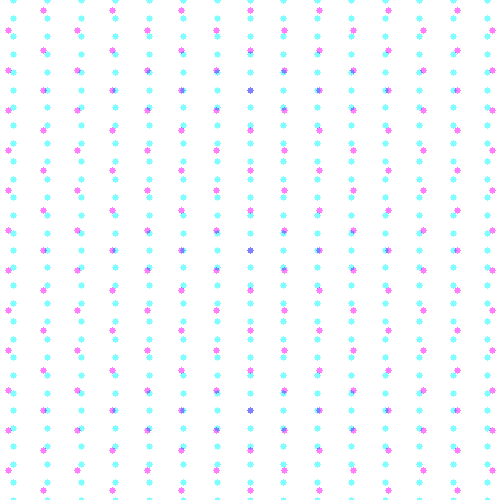



Substrate(111)//Target(011), θ=0.0°, overlapping=921px


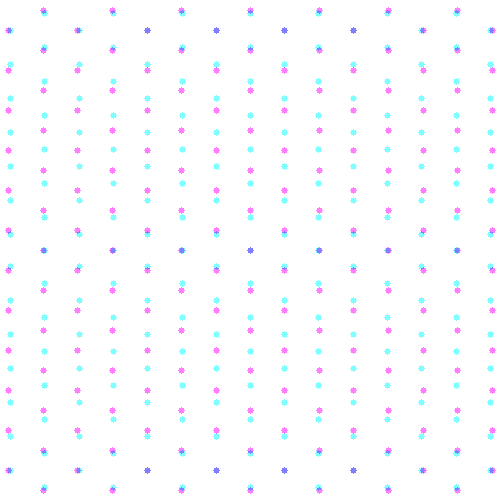



Substrate(111)//Target(101), θ=0.0°, overlapping=921px


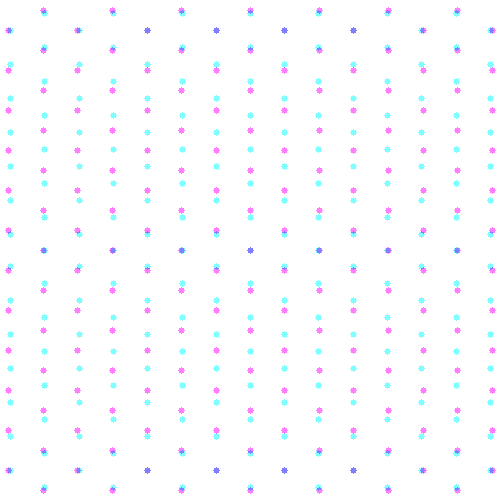

In [ ]:
simulate_matching(crystall["Ge"], crystall["Pt2Ge"], thresh=600)